## Data Augmentation and Processing Notebook 
### Using RapidAPI to scrape Zillow data

### Key attributes needs for analysis are Zestimate, price per square ft and rentZestimate

We are using Georgia (GA) Listing data to get all the addresses of properties which are on interest. We then use following sources to augment that data:
* Zillow
* IRS (Tax data)
* FHFA (HPI data)

The data is then further transformed by feature extraction or feature engineeting work, for example:
* Schools (from Zillow)
* Lot Size (from Zillow and GA Listings)

In [1]:
#!pip install googlesearch-python

In [9]:
#pip install google

     |████████████████████████████████| 45 kB 472 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


### Importing Key Libraries

In [145]:
from googlesearch import search # get zpid
import pandas as pd
import numpy as np
import requests
import json
import time
import io
import plotly.express as px

# show all columns
pd.set_option('display.max_columns', None)

### <font color=blue> This function use google search and find zpid (primary key for zillow)
#### RapidAPI requires zpid

In [2]:
def get_zpid(street=None, city=None, state=None, zip_code=None, full_address=None):
  # get search query string
  if full_address == None:
    try:
      query = '{0}, {1}, {2} {3} zillow home details'.format(street, city, state, str(zip_code))
    except:
      return 'Please enter a query string or address details'
  else:
    query = full_address + ' zillow home details'

  # get google search results
  search_results = search(query, tld='com', lang='en', num=3, start=0, stop=1, pause=0)
  search_results_list = [u for u in search_results]
  url = search_results_list[0] # extract first returned result
  
  # return zpid
  try:
    return [x for x in url.split('/') if 'zpid' in x][0].split('_')[0]
  except:
    return None

### <font color=blue> Register and test the Rapid API key

In [3]:
rapid_api_key = "please_use_a_valid_key"

In [4]:
def get_property_detail(rapid_api_key, zpid):
  # get property details from API
  url = "https://zillow-com1.p.rapidapi.com/property"

  querystring = {"zpid":zpid} # zpid

  headers = {
    "X-RapidAPI-Host": "zillow-com1.p.rapidapi.com",
    "X-RapidAPI-Key": rapid_api_key # your key here
  }

  # request data
  return requests.request("GET", url, headers=headers, params=querystring)


Testing the API

In [5]:
import requests

url = "https://zillow-com1.p.rapidapi.com/property"

querystring = {"zpid":"2080998890"}

headers = {
    "X-RapidAPI-Key": "rapid_api_key",
    "X-RapidAPI-Host": "zillow-com1.p.rapidapi.com"
}

response = requests.request("GET", url, headers=headers, params=querystring)

print(response.text)

{"listingProvider":{"enhancedVideoURL":null,"showNoContactInfoMessage":false,"postingGroupName":null,"isZRMSourceText":null,"showLogos":null,"disclaimerText":null,"sourceText":null,"title":"Listing Provided by","logos":{},"postingWebsiteURL":null,"agentLicenseNumber":null,"postingWebsiteLinkText":"See listing website","enhancedDescriptionText":null,"agentName":null},"buildingPermits":null,"propertyTaxRate":1.01,"contact_recipients":[{"agent_reason":1,"zpro":null,"recent_sales":0,"review_count":56,"display_name":"Jim Pullin","zuid":"X1-ZU11t0lr5j8rqx5_34dhh","rating_average":5,"badge_type":"Premier Agent","phone":{"prefix":"207","areacode":"206","number":"8763"},"image_url":"https:\/\/photos.zillowstatic.com\/h_n\/ISfkgeu1boe63o1000000000.jpg"}],"solarPotential":null,"longitude":-122.34212,"countyFIPS":null,"cityId":16037,"timeOnZillow":"611 days","url":"\/homedetails\/757-Hayes-St-Seattle-WA-98109\/2080998890_zpid\/","zestimate":null,"imgSrc":"https:\/\/photos.zillowstatic.com\/fp\/306

In [6]:
# property address
property_address = "84 Whippoorwill Circle, Kingsland, GA 31548" # https://www.zillow.com/homedetails/11622-Pure-Pebble-Dr-Riverview-FL-33569/66718658_zpid/

# search query
query = property_address + ' zillow home details'
print('Search this phrase in Google Search:', query)

Search this phrase in Google Search: 84 Whippoorwill Circle, Kingsland, GA 31548 zillow home details


In [7]:
# google search results
search_results = search(query, tld='com', lang='en', num=3, start=0, stop=3, pause=0)
search_results_list = [u for u in search_results] # get all results
search_results_list

['https://www.zillow.com/homedetails/84-Whippoorwill-Cir-Kingsland-GA-31548/76375189_zpid/',
 'https://www.compass.com/listing/84-whippoorwill-circle-kingsland-ga-31548/1020322606183510697/',
 'https://www.coldwellbankerhomes.com/ga/kingsland/84-whippoorwill-circle/pid_46488818/']

In [8]:
# get the first search result
url = search_results_list[0] # extract first returned result
url

'https://www.zillow.com/homedetails/84-Whippoorwill-Cir-Kingsland-GA-31548/76375189_zpid/'

In [9]:
# extract the zpid
zpid = [x for x in url.split('/') if 'zpid' in x][0].split('_')[0]
print('Zpid of the property is:', zpid )

Zpid of the property is: 76375189


In [10]:
# get property details from API
url = "https://zillow-com1.p.rapidapi.com/property"

querystring = {"zpid":zpid} # zpid

headers = {
    "X-RapidAPI-Host": "zillow-com1.p.rapidapi.com",
    "X-RapidAPI-Key": rapid_api_key # your key here
}

# request data
response = requests.request("GET", url, headers=headers, params=querystring)
# show success
response.status_code # 200 is success!

200

In [11]:
response.json()

{'listingProvider': None,
 'buildingPermits': None,
 'propertyTaxRate': 0.98,
 'contact_recipients': [{'agent_reason': 1,
   'zpro': None,
   'recent_sales': 1,
   'review_count': 66,
   'display_name': 'Hannah Melton',
   'zuid': 'X1-ZUzlemig891155_8qndh',
   'rating_average': 5,
   'badge_type': 'Premier Agent',
   'phone': {'prefix': '380', 'areacode': '912', 'number': '3440'},
   'image_url': 'https://photos.zillowstatic.com/h_n/ISfo72urg9xp1t1000000000.jpg'}],
 'solarPotential': {'sunScore': 64.35,
  'solarFactor': 3.04,
  'buildFactor': 52,
  'climateFactor': 6.67,
  'electricityFactor': 2.64},
 'longitude': -81.66023,
 'countyFIPS': '13039',
 'cityId': 52779,
 'timeOnZillow': '146 days',
 'url': '/homedetails/84-Whippoorwill-Cir-Kingsland-GA-31548/76375189_zpid/',
 'zestimate': 235700,
 'imgSrc': 'https://photos.zillowstatic.com/fp/9d94004ba25c8463f8d134d7a4e7f3fc-p_d.jpg',
 'zpid': 76375189,
 'zipcode': '31548',
 'livingAreaValue': 1618,
 'zestimateLowPercent': None,
 'isListed

In [12]:
# transform data to pandas dataframe
df_property_detail = pd.json_normalize(data=response.json())
print('Num of rows:', len(df_property_detail))
print('Num of cols:', len(df_property_detail.columns))
df_property_detail.head()

Num of rows: 1
Num of cols: 257


,listingProvider,buildingPermits,propertyTaxRate,contact_recipients,longitude,countyFIPS,cityId,timeOnZillow,url,zestimate,imgSrc,zpid,zipcode,livingAreaValue,zestimateLowPercent,isListedByOwner,propertyTypeDimension,streetAddress,county,taxHistory,stateId,countyId,timeZone,homeType,livingAreaUnits,comingSoonOnMarketDate,livingArea,bathrooms,annualHomeownersInsurance,state,rentZestimate,building,brokerId,yearBuilt,brokerageName,dateSold,price,pageViewCount,description,homeStatus,homeFacts,latitude,datePosted,bedrooms,nearbyHomes,monthlyHoaFee,priceHistory,favoriteCount,schools,zestimateHighPercent,mlsid,city,providerListingID,country,currency,contingentListingType,solarPotential.sunScore,solarPotential.solarFactor,solarPotential.buildFactor,solarPotential.climateFactor,solarPotential.electricityFactor,resoFacts.hasAttachedProperty,resoFacts.frontageType,resoFacts.poolFeatures,resoFacts.flooring,resoFacts.foundationDetails,resoFacts.accessibilityFeatures,resoFacts.hasGarage,resoFacts.hasPetsAllowed,resoFacts.bodyType,resoFacts.topography,resoFacts.landLeaseExpirationDate,resoFacts.hasAdditionalParcels,resoFacts.waterViewYN,resoFacts.atAGlanceFacts,resoFacts.offerReviewDate,resoFacts.aboveGradeFinishedArea,resoFacts.buyerAgencyCompensationType,resoFacts.carportSpaces,resoFacts.cityRegion,resoFacts.mainLevelBathrooms,resoFacts.hasPrivatePool,resoFacts.associationFeeIncludes,resoFacts.waterSource,resoFacts.coveredSpaces,resoFacts.inclusions,resoFacts.hasFireplace,resoFacts.zoningDescription,resoFacts.garageSpaces,resoFacts.sewer,resoFacts.elevationUnits,resoFacts.exclusions,resoFacts.mainLevelBedrooms,resoFacts.numberOfUnitsVacant,resoFacts.hasWaterfrontView,resoFacts.listAOR,resoFacts.lotSize,resoFacts.entryLevel,resoFacts.irrigationWaterRightsAcres,resoFacts.greenWaterConservation,resoFacts.stories,resoFacts.livingArea,resoFacts.numberOfUnitsInCommunity,resoFacts.listingTerms,resoFacts.otherStructures,resoFacts.associationFee,resoFacts.marketingType,resoFacts.greenIndoorAirQuality,resoFacts.greenSustainability,resoFacts.hasHomeWarranty,resoFacts.associationPhone,resoFacts.greenBuildingVerificationType,resoFacts.elementarySchool,resoFacts.bedrooms,resoFacts.architecturalStyle,resoFacts.listingId,resoFacts.structureType,resoFacts.interiorFeatures,resoFacts.horseAmenities,resoFacts.electric,resoFacts.developmentStatus,resoFacts.lotFeatures,resoFacts.roofType,resoFacts.waterSources,resoFacts.constructionMaterials,resoFacts.fireplaceFeatures,resoFacts.doorFeatures,resoFacts.appliances,resoFacts.daysOnZillow,resoFacts.bathroomsPartial,resoFacts.bathroomsHalf,resoFacts.depositsAndFees,resoFacts.canRaiseHorses,resoFacts.buildingName,resoFacts.hasAssociation,resoFacts.petsMaxWeight,resoFacts.commonWalls,resoFacts.totalActualRent,resoFacts.additionalParcelsDescription,resoFacts.associationName,resoFacts.allowedPets,resoFacts.communityFeatures,resoFacts.tenantPays,resoFacts.middleOrJuniorSchool,resoFacts.lotSizeDimensions,resoFacts.roadSurfaceType,resoFacts.hasOpenParking,resoFacts.yearBuilt,resoFacts.livingAreaRangeUnits,resoFacts.irrigationWaterRightsYN,resoFacts.bathroomsFull,resoFacts.horseYN,resoFacts.incomeIncludes,resoFacts.highSchool,resoFacts.leaseTerm,resoFacts.elevation,resoFacts.cropsIncludedYN,resoFacts.attic,resoFacts.subdivisionName,resoFacts.windowFeatures,resoFacts.ownership,resoFacts.woodedArea,resoFacts.middleOrJuniorSchoolDistrict,resoFacts.associationPhone2,resoFacts.buyerAgencyCompensation,resoFacts.heating,resoFacts.frontageLength,resoFacts.virtualTourURLUnbranded,resoFacts.associationAmenities,resoFacts.propertySubType,resoFacts.hasCooling,resoFacts.belowGradeFinishedArea,resoFacts.hasElectricOnProperty,resoFacts.foundationArea,resoFacts.zoning,resoFacts.hoaFee,resoFacts.livingAreaRange,resoFacts.basementYN,resoFacts.availabilityDate,resoFacts.waterBodyName,resoFacts.waterfrontFeatures,resoFacts.specialListingConditions,resoFacts.buildingAreaSource,resoFacts.taxAnnualAmount,resoFacts.parking,resoFacts.hasView,resoFa

In [13]:
# retrieve property detail elements
bedrooms = df_property_detail['bedrooms'].iloc[0]
bathrooms = df_property_detail['bathrooms'].iloc[0]
year_built = df_property_detail['yearBuilt'].iloc[0]
property_type = df_property_detail['homeType'].iloc[0]
living_area = df_property_detail['resoFacts.livingArea'].iloc[0]
lot_size = df_property_detail['resoFacts.lotSize'].iloc[0]
lot_dimensions = df_property_detail['resoFacts.lotSizeDimensions'].iloc[0]
zoning = df_property_detail['resoFacts.zoning'].iloc[0]
livingAreaValue = df_property_detail['livingAreaValue'].iloc[0]
schools = df_property_detail['schools'].iloc[0]
# estimates
zestimate = df_property_detail['zestimate'].iloc[0]
rent_zestimate = df_property_detail['rentZestimate'].iloc[0]

print('PROPERTY DETAILS FOR: ', property_address)
print('------------------------------------------------------------------')
print('  Bedrooms: {}'.format( bedrooms))
print('  Bathrooms: {}'.format( bathrooms))
print('  Year Built: {}'.format( year_built))
print('  Living Area: {}'.format( living_area))
print('  Lot Size: {}'.format( lot_size))
print('  Lot Dimensions: {}'.format( lot_dimensions))
print('  Zoning: {}'.format( zoning))
print('  livingAreaValue: {}'.format( livingAreaValue))
print('  schools: {}'.format( schools))
print('  Property Type: {}'.format( property_type))
print('  Zestimate:  {}'.format(zestimate))
print('  Rent Zestimate: {}'.format(rent_zestimate))

PROPERTY DETAILS FOR:  84 Whippoorwill Circle, Kingsland, GA 31548
------------------------------------------------------------------
  Bedrooms: 3
  Bathrooms: 2
  Year Built: 1986
  Living Area: 1,618 sqft
  Lot Size: None
  Lot Dimensions: None
  Zoning: None
  livingAreaValue: 1618
  schools: [{'link': 'https://www.greatschools.org/school?id=00276&state=GA', 'rating': 8, 'totalCount': 1, 'distance': 0.9, 'assigned': None, 'name': 'David L Rainer Elementary School', 'studentsPerTeacher': 16, 'isAssigned': True, 'size': 456, 'level': 'Primary', 'grades': 'PK-5', 'type': 'Public'}, {'link': 'https://www.greatschools.org/school?id=00278&state=GA', 'rating': 6, 'totalCount': 1, 'distance': 2.2, 'assigned': None, 'name': 'Camden Middle School', 'studentsPerTeacher': 16, 'isAssigned': True, 'size': 1046, 'level': 'Middle', 'grades': '6-8', 'type': 'Public'}, {'link': 'https://www.greatschools.org/school?id=00275&state=GA', 'rating': 9, 'totalCount': 1, 'distance': 3.6, 'assigned': None, '

### <font color=blue> The Short Look Up csv file created from data provided by Haystack, but consists of only 4 columns

In [89]:
# read file
df_upload = pd.read_csv('short_lookup.csv')
print('Num of rows:', len(df_upload))
df_upload.head()

Num of rows: 5146


,address,city,state,zip
0,101 College Street,Kingsland,Georgia,31548
1,169 School House Creek Drive,Saint Marys,Georgia,31558
2,1621 Sandpiper Court,Saint Marys,Georgia,31558
3,346 Laurel Landing Boulevard,Kingsland,Georgia,31548
4,81 Ossabaw Way,Waverly,Georgia,31565


### <font color=blue> This is a one time data pull script, do not run again!

In [19]:
# create empty list to store api response for property details
df_list = []
zpid_list = []

# iterate through dataframe
for index, row in df_upload.iterrows():
  # get property address attributes by column name
  street = row['address']
  city = row['city']
  state = row['state']
  zip_code = row['zip'] 

  # get zpid
  zpid = get_zpid(street=street, city=city, state=state, zip_code=zip_code)
  zpid_list.append(zpid)

  # wait 1 second to not overload Google Search
  time.sleep(1.5)

  # get property details
  # catch errors (possibly no zpid)
  try:
    response = get_property_detail(rapid_api_key, zpid)
    _df = pd.json_normalize(data=response.json())
    # append data to list of property details
    df_list.append(_df)
  except:
    print('Unable to retrieve data for : {0}, {1}, {2}, {3}'.format(street, city, state, zip_code))

Unable to retrieve data for : 4342 White Surrey Drive NW, Kennesaw, Georgia, 30144


In [21]:
# join property details data
df_prop_detail = pd.concat(df_list)
df_prop_detail.head()

In [251]:
len(df_prop_detail.zpid.unique())

4609

### <font color=blue> We are saving the zillow data with 200+ attributes, which will save us from re-running the Rapid API code

In [ ]:
#Save data to a file for manual inspection
df_prop_detail.to_csv('full_output.csv', index=False)

### Given the number of columns the data was manually cleaned

In [103]:
df_scrape = pd.read_csv('manual_review_of_scrape_zdata.csv')

In [104]:
# join original dataset to property details
# create new column for zpid
df_upload['zpid'] = zpid_list

In [105]:
df_scrape.shape

(5145, 37)

In [106]:
df_upload.shape

(5146, 5)

In [107]:
df_upload.head()

,address,city,state,zip,zpid
0,101 College Street,Kingsland,Georgia,31548,2064281489
1,169 School House Creek Drive,Saint Marys,Georgia,31558,91030716
2,1621 Sandpiper Court,Saint Marys,Georgia,31558,111242225
3,346 Laurel Landing Boulevard,Kingsland,Georgia,31548,2090936200
4,81 Ossabaw Way,Waverly,Georgia,31565,2064330080


In [108]:
df_upload['zpid'].isna().sum()

110

In [109]:
df_scrape['zpid'].isna().sum()

114

In [111]:
df_scrape[df_scrape['zpid'].isna()].head(5)

,zpid,propertyTaxRate,rentZestimate,zestimate,pricePerSquareFoot,propertyTypeDimension,livingArea,bathrooms,bedrooms,annualHomeownersInsurance,monthlyHoaFee,taxAnnualAmount,yearBuilt,dateSold,price,pageViewCount,description,homeStatus,favoriteCount,schools,streetAddress,zipcode,city,hasAttachedProperty,poolFeatures,flooring,hasGarage,parking,hasWaterfrontView,lotSize,architecturalStyle,structureType,appliances,communityFeatures,propertyCondition,utilities,url
221,NaN,99999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
226,NaN,99999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
312,NaN,99999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
313,NaN,99999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
326,NaN,99999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [112]:
df_scrape = df_scrape[df_scrape['propertyTaxRate'] != 99999]

<font color = red> We can delete the records that did not give us a match from zillow 

In [113]:
df_scrape.shape

(5031, 37)

In [115]:
print(df_upload['zpid'].dtype)
print(df_scrape['zpid'].dtype)

object
float64


In [116]:
df_upload['zpid'] = df_upload['zpid'].astype(float)

In [249]:
len(df_upload.zpid.unique())

4612

### <font color='blue'> This section combines original data with zillow provided data
<font color='green'> The df_upload_unique is simply the unique addresses that we loaded before pulling data from Zillow API. The idea is to merge unique addresses with zillow  data
The output of this process is "df_join" data frame, the idea being we have the relevant zillow information with zpid and original addresses that we used to request zillow data 

In [253]:
df_upload_unique = df_upload.drop_duplicates(subset=['zpid'], keep='first')

In [250]:
len(df_scrape.zpid.unique())

4608

#### <font color=blue> There are dupicate properties in the Georgia Listing data, we will keep first hit from Zillow

In [254]:
df_scrape_unique = df_scrape.drop_duplicates(subset=['zpid'], keep='first')

In [255]:
df_scrape_unique.shape

(4608, 37)

In [256]:
df_upload_unique.shape

(4612, 5)

In [257]:
df_join = pd.merge(df_upload_unique, df_scrape_unique, how='left', on='zpid')
print('Num of columns:', len(df_join.columns))
df_join.head()

Num of columns: 41


,address,city_x,state,zip,zpid,propertyTaxRate,rentZestimate,zestimate,pricePerSquareFoot,propertyTypeDimension,livingArea,bathrooms,bedrooms,annualHomeownersInsurance,monthlyHoaFee,taxAnnualAmount,yearBuilt,dateSold,price,pageViewCount,description,homeStatus,favoriteCount,schools,streetAddress,zipcode,city_y,hasAttachedProperty,poolFeatures,flooring,hasGarage,parking,hasWaterfrontView,lotSize,architecturalStyle,structureType,appliances,communityFeatures,propertyCondition,utilities,url
0,101 College Street,Kingsland,Georgia,31548,2.064281e+09,0.98,NaN,NaN,162.0,Single Family,2103.0,2.0,4.0,1428.0,8.0,3670.0,2020.0,5/31/22,339900.0,0.0,"Looking for your new ""Home Sweet Home"" that ha...",RECENTLY_SOLD,0.0,[{'link': 'https://www.greatschools.org/school...,101 College St,31548.0,Kingsland,False,NaN,"['Carpet', 'Tile']",True,2.0,NaN,0.45 Acres,Other,NaN,"['Some Electric Appliances', 'Dishwasher', 'Di...","['Street Lights', 'Sidewalks', 'Walk to School']",NaN,"['Cable Available', 'Sewer Available', 'Sewer ...",/homedetails/101-College-St-Kingsland-GA-31548...
1,169 School House Creek Drive,Saint Marys,Georgia,31558,9.103072e+07,0.98,2600.0,325200.0,134.0,Single Family,2269.0,3.0,5.0,1281.0,NaN,3211.0,2004.0,5/17/22,305000.0,6.0,"Hard to find 5 bedroom, 3 bath home in SugarMi...",RECENTLY_SOLD,0.0,[{'link': 'https://www.greatschools.org/school...,169 School House Creek Dr,31558.0,Saint Marys,False,NaN,"['Carpet', 'Laminate', 'Vinyl']",True,0.0,NaN,"7,840 sqft",Traditional,House,"['Dishwasher', 'Oven/Range (Combo)', 'Refriger...","['Sidewalks', 'Street Lights']",Resale,"['Underground Utilities', 'Cable Available', '...",/homedetails/169-School-House-Creek-Dr-Saint-M...
2,1621 Sandpiper Court,Saint Marys,Georgia,31558,1.112422e+08,0.98,1999.0,340500.0,173.0,Single Family,1846.0,2.0,3.0,1344.0,210.0,3618.0,2004.0,5/13/22,320000.0,20.0,"Beautiful, coastal patio home with calming ""Se...",RECENTLY_SOLD,0.0,[{'link': 'https://www.greatschools.org/school...,1621 Sandpiper Ct,31558.0,Saint Marys,False,['None'],['Tile'],True,2.0,NaN,"8,276 sqft",Patio Home,NaN,"['Dryer', 'Dishwasher', 'Disposal', 'Microwave...","['Boat Facilities', 'Gated', 'Park', 'Street L...",NaN,"['Sewer Available', 'Sewer Connected', 'Underg...",/homedetails/1621-Sandpiper-Ct-Saint-Marys-GA-...
3,346 Laurel Landing Boulevard,Kingsland,Georgia,31548,2.090936e+09,0.98,1999.0,NaN,NaN,Condo,1953.0,2.0,3.0,0.0,79.0,NaN,2018.0,NaN,0.0,0.0,New Construction. Stucco and stone exterior. L...,OTHER,0.0,[{'link': 'https://www.greatschools.org/school...,346 Laurel Landing Blvd,31548.0,Kingsland,False,NaN,NaN,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/homedetails/346-Laurel-Landing-Blvd-Kingsland...
4,81 Ossabaw Way,Waverly,Georgia,31565,2.064330e+09,0.98,NaN,NaN,202.0,Single Family,1835.0,2.0,3.0,1554.0,100.0,104.0,2022.0,8/15/22,369900.0,5.0,**Completion scheduled for end of August. **P...,RECENTLY_SOLD,0.0,[{'link': 'https://www.greatschools.org/school...,81 Ossabaw Way,31565.0,Waverly,False,NaN,['Tile'],True,2.0,NaN,1.21 Acres,Traditional,House,"['Dishwasher', 'Microwave', 'Oven/Range (Combo...","['Clubhouse', 'Gated', 'Golf', 'Lake', 'Fitnes...",New Construction,"['Electricity Available', 'Water Available']",/homedetails/81-Ossabaw-Way-Waverly-GA-31565/2...


In [258]:
df_join = df_join[df_join['zpid'].notna()]

In [259]:
df_join['rentZestimate'].isna().sum()/len(df_join)

0.13641292561266535

<font color = 'red'> 13.6% of rent zestimate is missing and we can use missingpy to impute it

In [260]:
df_join.isna().sum()

address                         0
city_x                          0
state                           0
zip                             0
zpid                            0
propertyTaxRate                 3
rentZestimate                 629
zestimate                     931
pricePerSquareFoot            469
propertyTypeDimension           3
livingArea                    160
bathrooms                     144
bedrooms                      184
annualHomeownersInsurance       3
monthlyHoaFee                2893
taxAnnualAmount               562
yearBuilt                     164
dateSold                      584
price                           3
pageViewCount                   4
description                     6
homeStatus                      3
favoriteCount                   4
schools                         3
streetAddress                   3
zipcode                         3
city_y                          3
hasAttachedProperty             3
poolFeatures                 3038
flooring      

In [262]:
df_join.columns

Index(['address', 'city_x', 'state', 'zip', 'zpid', 'propertyTaxRate',
       'rentZestimate', 'zestimate', 'pricePerSquareFoot',
       'propertyTypeDimension', 'livingArea', 'bathrooms', 'bedrooms',
       'annualHomeownersInsurance', 'monthlyHoaFee', 'taxAnnualAmount',
       'yearBuilt', 'dateSold', 'price', 'pageViewCount', 'description',
       'homeStatus', 'favoriteCount', 'schools', 'streetAddress', 'zipcode',
       'city_y', 'hasAttachedProperty', 'poolFeatures', 'flooring',
       'hasGarage', 'parking', 'hasWaterfrontView', 'lotSize',
       'architecturalStyle', 'structureType', 'appliances',
       'communityFeatures', 'propertyCondition', 'utilities', 'url'],
      dtype='object')

<font color='blue'> We are using a subset of attributes that are useful based on numeric values, or attributes that can be transformed

In [332]:
remaining_tmp = df_join[['zpid','propertyTaxRate',
       'pricePerSquareFoot',
       'propertyTypeDimension',
       'annualHomeownersInsurance', 'monthlyHoaFee', 'taxAnnualAmount',
       'dateSold', 'pageViewCount', 'description',
       'homeStatus', 'favoriteCount', 'schools', 'streetAddress',
       'hasAttachedProperty', 'poolFeatures', 'flooring',
       'hasGarage', 'parking', 'hasWaterfrontView', 'lotSize',
       'architecturalStyle', 'structureType', 'appliances',
       'communityFeatures', 'propertyCondition', 'utilities', 'url']]

In [330]:
remaining_tmp.shape

(4611, 27)

<font color='red'> Before imputation we want to just subset the attrinbutes in a data frame that can be used as an input to the imputation process

In [264]:
tmp = df_join[['zpid', 'zip',
       'rentZestimate', 'zestimate', 
       'livingArea', 'bathrooms', 'bedrooms',
       'yearBuilt', 'price']]

In [265]:
tmp.head()

,zpid,zip,rentZestimate,zestimate,livingArea,bathrooms,bedrooms,yearBuilt,price
0,2.064281e+09,31548,NaN,NaN,2103.0,2.0,4.0,2020.0,339900.0
1,9.103072e+07,31558,2600.0,325200.0,2269.0,3.0,5.0,2004.0,305000.0
2,1.112422e+08,31558,1999.0,340500.0,1846.0,2.0,3.0,2004.0,320000.0
3,2.090936e+09,31548,1999.0,NaN,1953.0,2.0,3.0,2018.0,0.0
4,2.064330e+09,31565,NaN,NaN,1835.0,2.0,3.0,2022.0,369900.0


In [331]:
tmp.shape

(4611, 9)

### <font color='blue'> Imputing Missing Values
In this section we will impute following missing values:
* 'rentZestimate', 
* 'zestimate', 
* 'livingArea', 
* 'bathrooms', 
* 'bedrooms',
* 'yearBuilt', 
* 'price

In [132]:
pip install missingpy

     |████████████████████████████████| 49 kB 4.2 MB/s eta 0:00:011
Note: you may need to restart the kernel to use updated packages.


In [167]:
import sys
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
import seaborn as sns
import matplotlib.pyplot as plt

In [266]:
from missingpy import MissForest
imputer = MissForest()
df_new = imputer.fit_transform(tmp)

/Users/nimitsharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/nimitsharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/nimitsharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/nimitsharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/nimitsharma/o

Iteration: 0


/Users/nimitsharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/nimitsharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/nimitsharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/nimitsharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/nimitsharma/o

Iteration: 1


/Users/nimitsharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/nimitsharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/nimitsharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/nimitsharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/nimitsharma/o

Iteration: 2


/Users/nimitsharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/nimitsharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/nimitsharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/nimitsharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/nimitsharma/o

Iteration: 3


/Users/nimitsharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/nimitsharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/nimitsharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/nimitsharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/nimitsharma/o

Iteration: 4


/Users/nimitsharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/nimitsharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/nimitsharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/nimitsharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/nimitsharma/o

Iteration: 5


In [267]:
df_new.shape

(4611, 9)

In [268]:
df_imputed = pd.DataFrame(df_new, columns = ['zpid','zip',
       'rentZestimate_i', 'zestimate_i', 
       'livingArea_i', 'bathrooms_i', 'bedrooms_i',
       'yearBuilt_i', 'price_i'])

print(df_imputed.shape)
print(type(df_imputed))


(4611, 9)
<class 'pandas.core.frame.DataFrame'>


In [269]:
len(tmp.zpid.unique())

4611

In [270]:
len(tmp.zpid.unique())

4611

In [271]:
df_imputed.isna().sum()

zpid               0
zip                0
rentZestimate_i    0
zestimate_i        0
livingArea_i       0
bathrooms_i        0
bedrooms_i         0
yearBuilt_i        0
price_i            0
dtype: int64

In [272]:
tmp.isna().sum()

zpid               0
zip                0
rentZestimate    629
zestimate        931
livingArea       160
bathrooms        144
bedrooms         184
yearBuilt        164
price              3
dtype: int64

In [273]:
print(tmp.shape)
print(df_imputed.shape)

(4611, 9)
(4611, 9)


In [274]:
tmp.set_index('zpid')
df_imputed.set_index('zpid')

,zip,rentZestimate_i,zestimate_i,livingArea_i,bathrooms_i,bedrooms_i,yearBuilt_i,price_i
zpid,,,,,,,,
2.064281e+09,31548.0,2175.41,347514.00,2103.0,2.0,4.0,2020.0,339900.0
9.103072e+07,31558.0,2600.00,325200.00,2269.0,3.0,5.0,2004.0,305000.0
1.112422e+08,31558.0,1999.00,340500.00,1846.0,2.0,3.0,2004.0,320000.0
2.090936e+09,31548.0,1999.00,326164.00,1953.0,2.0,3.0,2018.0,0.0
2.064330e+09,31565.0,1939.51,365974.43,1835.0,2.0,3.0,2022.0,369900.0
...,...,...,...,...,...,...,...,...
1.108403e+08,30668.0,1900.00,421500.00,2000.0,2.0,3.0,2004.0,399900.0
7.661808e+07,30673.0,2049.00,350100.00,4003.0,4.0,4.0,1817.0,335000.0
7.661809e+07,30673.0,3599.00,384523.00,3808.0,4.0,5.0,1828.0,425000.0


<font color='red'> The concatenation refers to original values and imputed values within the same data frame

In [275]:
df_concat = pd.merge(tmp, df_imputed, how="inner", on="zpid")

In [276]:
df_concat.shape

(4611, 17)

In [286]:
df_concat.head(10)

,zpid,zip_x,rentZestimate,zestimate,livingArea,bathrooms,bedrooms,yearBuilt,price,zip_y,rentZestimate_i,zestimate_i,livingArea_i,bathrooms_i,bedrooms_i,yearBuilt_i,price_i
0,2.064281e+09,31548,NaN,NaN,2103.0,2.0,4.0,2020.0,339900.0,31548.0,2175.41,347514.00,2103.00,2.00,4.00,2020.00,339900.0
1,9.103072e+07,31558,2600.0,325200.0,2269.0,3.0,5.0,2004.0,305000.0,31558.0,2600.00,325200.00,2269.00,3.00,5.00,2004.00,305000.0
2,1.112422e+08,31558,1999.0,340500.0,1846.0,2.0,3.0,2004.0,320000.0,31558.0,1999.00,340500.00,1846.00,2.00,3.00,2004.00,320000.0
3,2.090936e+09,31548,1999.0,NaN,1953.0,2.0,3.0,2018.0,0.0,31548.0,1999.00,326164.00,1953.00,2.00,3.00,2018.00,0.0
4,2.064330e+09,31565,NaN,NaN,1835.0,2.0,3.0,2022.0,369900.0,31565.0,1939.51,365974.43,1835.00,2.00,3.00,2022.00,369900.0
5,7.637250e+07,31558,3177.0,51000.0,2557.0,3.0,4.0,1998.0,499000.0,31558.0,3177.00,51000.00,2557.00,3.00,4.00,1998.00,499000.0
6,2.073578e+09,31548,2226.0,356100.0,2117.0,2.0,3.0,2021.0,340000.0,31548.0,2226.00,356100.00,2117.00,2.00,3.00,2021.00,340000.0
7,9.102889e+07,31548,2600.0,432800.0,2628.0,3.0,3.0,1999.0,415000.0,31548.0,2600.00,432800.00,2628.00,3.00,3.00,1999.00,415000.0
8,2.067292e+09,31565,NaN,NaN,NaN,NaN,NaN,NaN,0.0,31565.0,2175.38,341579.00,2246.35,2.82,3.87,2019.52,0.0
9,7.637437e+07,31569,3751.0,603000.0,2224.0,3.0,3.0,1997.0,571700.0,31569.0,3751.00,603000.00,2224.00,3.00,3.00,1997.00,571700.0


### <font color='blue'> Validation of Imputation Process
We want to ensure that the distribution of data did not change after the imputation and the descriptive statistics makes sense

,count,mean,std,min,25%,50%,75%,max
rentZestimate,3982.0,2493.181567,623.014387,145.0,2080.0,2389.0,2849.000,10386.0
rentZestimate_i,4611.0,2489.584460,608.483401,145.0,2086.0,2394.0,2839.265,10386.0


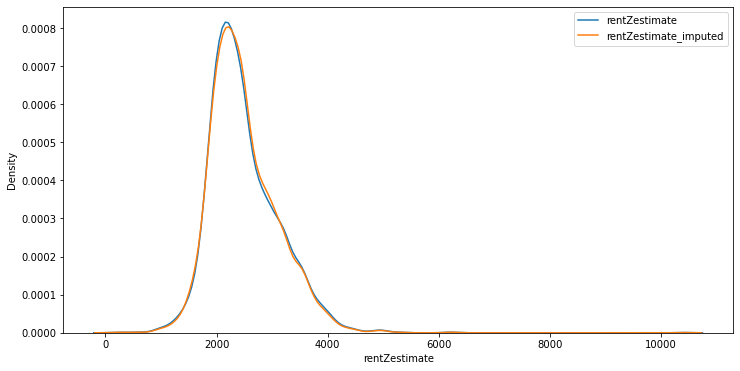

In [278]:
plt.figure(figsize=(12,6))
sns.kdeplot(tmp['rentZestimate'], label='rentZestimate', legend=True)
sns.kdeplot(df_imputed['rentZestimate_i'], label='rentZestimate_imputed', legend=True)
plt.legend();
# Stats
df_concat[['rentZestimate', 'rentZestimate_i']].describe().T

,count,mean,std,min,25%,50%,75%,max
zestimate,3680.0,429131.689946,105649.736027,51000.0,350900.0,412150.0,494975.0,1587200.0
zestimate_i,4611.0,428932.870924,105754.526521,51000.0,350080.5,413400.0,496638.0,1587200.0


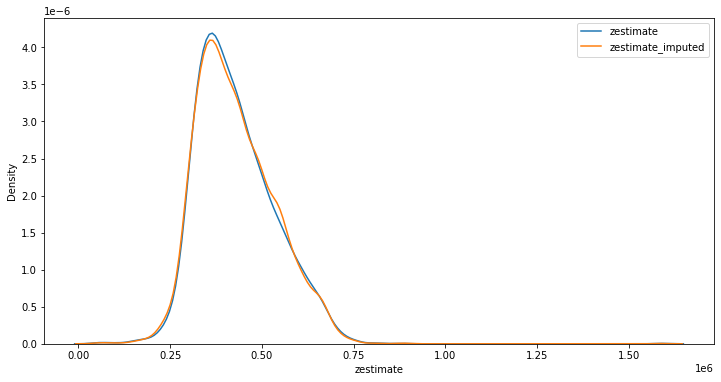

In [279]:
plt.figure(figsize=(12,6))
sns.kdeplot(tmp['zestimate'], label='zestimate', legend=True)
sns.kdeplot(df_imputed['zestimate_i'], label='zestimate_imputed', legend=True)
plt.legend();
# Stats
df_concat[['zestimate', 'zestimate_i']].describe().T

,count,mean,std,min,25%,50%,75%,max
livingArea,4451.0,2265.090317,1016.013336,0.0,1682.5,2249.0,2844.5,8354.0
livingArea_i,4611.0,2242.105879,1011.387379,0.0,1646.0,2232.0,2823.0,8354.0


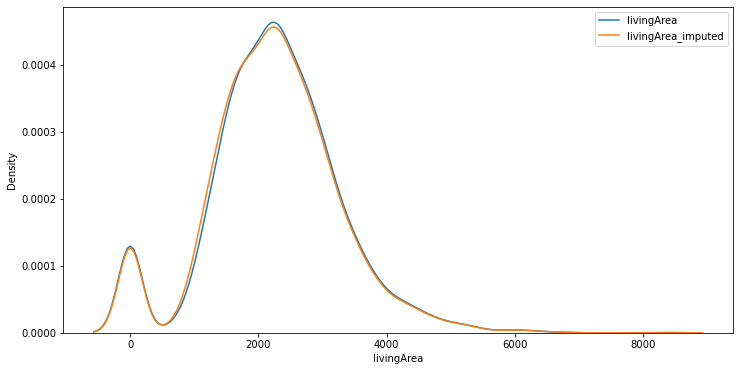

In [280]:
plt.figure(figsize=(12,6))
sns.kdeplot(tmp['livingArea'], label='livingArea', legend=True)
sns.kdeplot(df_imputed['livingArea_i'], label='livingArea_imputed', legend=True)
plt.legend();
# Stats
df_concat[['livingArea', 'livingArea_i']].describe().T

,count,mean,std,min,25%,50%,75%,max
bedrooms,4427.0,3.769596,0.928899,0.0,3.0,4.0,4.0,9.0
bedrooms_i,4611.0,3.729291,0.959218,0.0,3.0,4.0,4.0,9.0


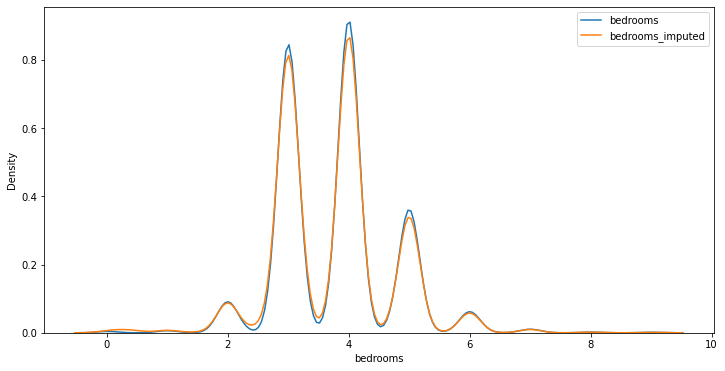

In [281]:
plt.figure(figsize=(12,6))
sns.kdeplot(tmp['bedrooms'], label='bedrooms', legend=True)
sns.kdeplot(df_imputed['bedrooms_i'], label='bedrooms_imputed', legend=True)
plt.legend();
# Stats
df_concat[['bedrooms', 'bedrooms_i']].describe().T

,count,mean,std,min,25%,50%,75%,max
yearBuilt,4447.0,1992.481448,26.432049,1817.0,1978.0,1998.0,2015.0,2023.0
yearBuilt_i,4611.0,1992.518000,26.277298,1817.0,1978.0,1998.0,2015.0,2023.0


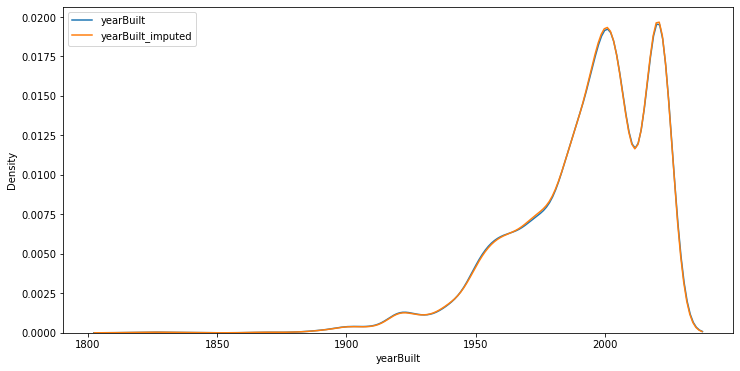

In [282]:
plt.figure(figsize=(12,6))
sns.kdeplot(tmp['yearBuilt'], label='yearBuilt', legend=True)
sns.kdeplot(df_imputed['yearBuilt_i'], label='yearBuilt_imputed', legend=True)
plt.legend();
# Stats
df_concat[['yearBuilt', 'yearBuilt_i']].describe().T

In [285]:
df_concat.to_csv('df_concat.csv', index=False)

In [284]:
df_concat.shape

(4611, 17)

In [287]:
df_concat.columns

Index(['zpid', 'zip_x', 'rentZestimate', 'zestimate', 'livingArea',
       'bathrooms', 'bedrooms', 'yearBuilt', 'price', 'zip_y',
       'rentZestimate_i', 'zestimate_i', 'livingArea_i', 'bathrooms_i',
       'bedrooms_i', 'yearBuilt_i', 'price_i'],
      dtype='object')

#### <font color='blue'> Assigning the imputed values to missing values

In [288]:
df_concat['rentZestimate'] = df_concat['rentZestimate'].fillna(df_concat['rentZestimate_i'])
df_concat['zestimate'] = df_concat['zestimate'].fillna(df_concat['zestimate_i'])
df_concat['livingArea'] = df_concat['livingArea'].fillna(df_concat['livingArea_i'])
df_concat['bathrooms'] = df_concat['bathrooms'].fillna(df_concat['bathrooms_i'])
df_concat['bedrooms'] = df_concat['bedrooms'].fillna(df_concat['bedrooms_i'])
df_concat['yearBuilt'] = df_concat['yearBuilt'].fillna(df_concat['yearBuilt_i'])

In [289]:
df_concat.drop(columns=['zip_x','zip_y',
       'rentZestimate_i', 'zestimate_i', 'livingArea_i', 'bathrooms_i',
       'bedrooms_i', 'yearBuilt_i', 'price_i'], inplace=True)

In [290]:
df_concat.shape

(4611, 8)

In [291]:
df_concat.head()

,zpid,rentZestimate,zestimate,livingArea,bathrooms,bedrooms,yearBuilt,price
0,2.064281e+09,2175.41,347514.00,2103.0,2.0,4.0,2020.0,339900.0
1,9.103072e+07,2600.00,325200.00,2269.0,3.0,5.0,2004.0,305000.0
2,1.112422e+08,1999.00,340500.00,1846.0,2.0,3.0,2004.0,320000.0
3,2.090936e+09,1999.00,326164.00,1953.0,2.0,3.0,2018.0,0.0
4,2.064330e+09,1939.51,365974.43,1835.0,2.0,3.0,2022.0,369900.0


In [294]:
df_upload.shape

(5146, 5)

In [295]:
df_upload_unique.shape

(4612, 5)

## <font color = blue> Putting the zillow data together by joining with imputed values, GA listings and de-duping
### <font color = blue> Process Steps:
* Create "df" as a temporary data frame that has zpid and imputed values as well as original addresses sent to zillow API
* Read the GA listings again into "df_orig" and join with df
* Merge the two data sets by creating a "final_df_start" data frame
* Then bring back all the remaining zilliw attrbutes that did not go through imputation but are useful, this data frame is called as "final_df_end"
* Save this data frame as "clean_df.csv", this will help other team members use this data


In [296]:
df = pd.merge(df_concat, df_upload_unique, how="inner", on="zpid")

In [297]:
df.shape

(4611, 12)

In [298]:
df.head()

,zpid,rentZestimate,zestimate,livingArea,bathrooms,bedrooms,yearBuilt,price,address,city,state,zip
0,2.064281e+09,2175.41,347514.00,2103.0,2.0,4.0,2020.0,339900.0,101 College Street,Kingsland,Georgia,31548
1,9.103072e+07,2600.00,325200.00,2269.0,3.0,5.0,2004.0,305000.0,169 School House Creek Drive,Saint Marys,Georgia,31558
2,1.112422e+08,1999.00,340500.00,1846.0,2.0,3.0,2004.0,320000.0,1621 Sandpiper Court,Saint Marys,Georgia,31558
3,2.090936e+09,1999.00,326164.00,1953.0,2.0,3.0,2018.0,0.0,346 Laurel Landing Boulevard,Kingsland,Georgia,31548
4,2.064330e+09,1939.51,365974.43,1835.0,2.0,3.0,2022.0,369900.0,81 Ossabaw Way,Waverly,Georgia,31565


In [318]:
df_orig = pd.read_csv('out_v2.csv')

In [319]:
df_orig.head()

,latitude,longitude,full_street_address,city,census_state_name,zip,square_footage,details,special_features,price,transaction_type,listing_status,listing_special_features,census_county_name,beds,baths_full,year_built
0,30.781796,-83.558475,505 S Lee Street,Quitman,Georgia,31643,1460,Detached,0,99000,1,1,0,"Brooks, GA",3.0,1.0,1910.0
1,30.864096,-81.622765,33 River Oaks Street,Woodbine,Georgia,31569,1254,Detached,0,245816,1,1,0,"Camden, GA",3.0,2.0,1985.0
2,30.762972,-81.660240,84 Whippoorwill Circle,Kingsland,Georgia,31548,1618,Detached,0,200000,1,1,0,"Camden, GA",3.0,2.0,1986.0
3,30.804209,-81.653325,101 College Street,Kingsland,Georgia,31548,2103,Detached,2,339900,1,1,2,"Camden, GA",4.0,2.0,2020.0
4,30.823195,-81.635187,241 Jake Colton Drive,Kingsland,Georgia,31548,2954,Detached,0,679900,1,1,0,"Camden, GA",4.0,3.0,2019.0


In [320]:
df_orig.shape

(10416, 17)

In [321]:
df_orig.rename(columns={"full_street_address": "address"}, inplace=True)

In [322]:
df_orig.shape

(10416, 17)

In [323]:
df.shape

(4611, 12)

In [368]:
df_orig.columns

Index(['latitude', 'longitude', 'address', 'city', 'census_state_name', 'zip',
       'square_footage', 'details', 'special_features', 'price',
       'transaction_type', 'listing_status', 'listing_special_features',
       'census_county_name', 'beds', 'baths_full', 'year_built'],
      dtype='object')

In [369]:
df.columns

Index(['zpid', 'rentZestimate', 'zestimate', 'livingArea', 'bathrooms',
       'bedrooms', 'yearBuilt', 'price', 'address', 'city', 'state', 'zip'],
      dtype='object')

In [333]:
final_df_start = pd.merge(df, df_orig, how="inner", on=['zip','city','address'])

In [366]:
final_df_start.shape

(4611, 26)

In [335]:
len(final_df_start.zpid.unique())

4611

In [336]:
final_df_start = final_df_start.drop_duplicates(subset=['zpid'], keep='first')

In [339]:
final_df_start.shape

(4611, 26)

In [340]:
final_df_end = pd.merge(final_df_start, remaining_tmp, how="inner", on=['zpid'])

In [341]:
final_df_end.shape

(4611, 53)

In [343]:
final_df_end.head()

,zpid,rentZestimate,zestimate,livingArea,bathrooms,bedrooms,yearBuilt,price_x,address,city,state,zip,latitude,longitude,census_state_name,square_footage,details,special_features,price_y,transaction_type,listing_status,listing_special_features,census_county_name,beds,baths_full,year_built,propertyTaxRate,pricePerSquareFoot,propertyTypeDimension,annualHomeownersInsurance,monthlyHoaFee,taxAnnualAmount,dateSold,pageViewCount,description,homeStatus,favoriteCount,schools,streetAddress,hasAttachedProperty,poolFeatures,flooring,hasGarage,parking,hasWaterfrontView,lotSize,architecturalStyle,structureType,appliances,communityFeatures,propertyCondition,utilities,url
0,2.064281e+09,2175.41,347514.00,2103.0,2.0,4.0,2020.0,339900.0,101 College Street,Kingsland,Georgia,31548,30.804209,-81.653325,Georgia,2103,Detached,2,339900,1,1,2,"Camden, GA",4.0,2.0,2020.0,0.98,162.0,Single Family,1428.0,8.0,3670.0,5/31/22,0.0,"Looking for your new ""Home Sweet Home"" that ha...",RECENTLY_SOLD,0.0,[{'link': 'https://www.greatschools.org/school...,101 College St,False,NaN,"['Carpet', 'Tile']",True,2.0,NaN,0.45 Acres,Other,NaN,"['Some Electric Appliances', 'Dishwasher', 'Di...","['Street Lights', 'Sidewalks', 'Walk to School']",NaN,"['Cable Available', 'Sewer Available', 'Sewer ...",/homedetails/101-College-St-Kingsland-GA-31548...
1,9.103072e+07,2600.00,325200.00,2269.0,3.0,5.0,2004.0,305000.0,169 School House Creek Drive,Saint Marys,Georgia,31558,30.767365,-81.588272,Georgia,2269,Detached,0,310000,1,1,0,"Camden, GA",5.0,3.0,2004.0,0.98,134.0,Single Family,1281.0,NaN,3211.0,5/17/22,6.0,"Hard to find 5 bedroom, 3 bath home in SugarMi...",RECENTLY_SOLD,0.0,[{'link': 'https://www.greatschools.org/school...,169 School House Creek Dr,False,NaN,"['Carpet', 'Laminate', 'Vinyl']",True,0.0,NaN,"7,840 sqft",Traditional,House,"['Dishwasher', 'Oven/Range (Combo)', 'Refriger...","['Sidewalks', 'Street Lights']",Resale,"['Underground Utilities', 'Cable Available', '...",/homedetails/169-School-House-Creek-Dr-Saint-M...
2,1.112422e+08,1999.00,340500.00,1846.0,2.0,3.0,2004.0,320000.0,1621 Sandpiper Court,Saint Marys,Georgia,31558,30.746731,-81.633995,Georgia,1846,Detached,0,315000,1,1,0,"Camden, GA",3.0,2.0,2004.0,0.98,173.0,Single Family,1344.0,210.0,3618.0,5/13/22,20.0,"Beautiful, coastal patio home with calming ""Se...",RECENTLY_SOLD,0.0,[{'link': 'https://www.greatschools.org/school...,1621 Sandpiper Ct,False,['None'],['Tile'],True,2.0,NaN,"8,276 sqft",Patio Home,NaN,"['Dryer', 'Dishwasher', 'Disposal', 'Microwave...","['Boat Facilities', 'Gated', 'Park', 'Street L...",NaN,"['Sewer Available', 'Sewer Connected', 'Underg...",/homedetails/1621-Sandpiper-Ct-Saint-Marys-GA-...
3,2.090936e+09,1999.00,326164.00,1953.0,2.0,3.0,2018.0,0.0,346 Laurel Landing Boulevard,Kingsland,Georgia,31548,30.791878,-81.676750,Georgia,1977,Detached,0,310000,1,1,0,"Camden, GA",3.0,2.0,2017.0,0.98,NaN,Condo,0.0,79.0,NaN,NaN,0.0,New Construction. Stucco and stone exterior. L...,OTHER,0.0,[{'link': 'https://www.greatschools.org/school...,346 Laurel Landing Blvd,False,NaN,NaN,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/homedetails/346-Laurel-Landing-Blvd-Kingsland...
4,2.064330e+09,1939.51,365974.43,1835.0,2.0,3.0,2022.0,369900.0,81 Ossabaw Way,Waverly,Georgia,31565,31.104492,-81.604486,Georgia,1835,Detached,2,369900,1,1,2,"Camden, GA",3.0,2.0,2022.0,0.98,202.0,Single Family,1554.0,100.0,104.0,8/15/22,5.0,**Completion scheduled for end of August. **P...,RECENTLY_SOLD,0.0,[{'link': 'https://www.greatschools.org/school...,81 Ossabaw Way,False,NaN,['Tile'],True,2.0,NaN,1.21 Acres,Traditional,House,"['Dishwasher', 'Microwave', 'Oven/Range (Combo...","['Clubhouse', 'Gated', 'Golf', 'Lake', 'Fitnes...",New Construction,"['Electricity Available', 'Water Available']",/homedetails/81-Ossabaw-Way-Waverly-GA-31565/2...


In [344]:
final_df_end.to_csv('clean_df.csv', index=False)

In [346]:
final_df_end.describe().T

,count,mean,std,min,25%,50%,75%,max
zpid,4611.0,4.649596e+08,7.928423e+08,1.409882e+07,1.489418e+07,7.112737e+07,2.377152e+08,2.146666e+09
rentZestimate,4611.0,2.489584e+03,6.084834e+02,1.450000e+02,2.086000e+03,2.394000e+03,2.839265e+03,1.038600e+04
zestimate,4611.0,4.289329e+05,1.057545e+05,5.100000e+04,3.500805e+05,4.134000e+05,4.966380e+05,1.587200e+06
livingArea,4611.0,2.242106e+03,1.011387e+03,0.000000e+00,1.646000e+03,2.232000e+03,2.823000e+03,8.354000e+03
bathrooms,4611.0,2.854486e+00,9.228547e-01,0.000000e+00,2.000000e+00,3.000000e+00,3.000000e+00,1.300000e+01
bedrooms,4611.0,3.729291e+00,9.592176e-01,0.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00,9.000000e+00
yearBuilt,4611.0,1.992518e+03,2.627730e+01,1.817000e+03,1.978000e+03,1.998000e+03,2.015000e+03,2.023000e+03
price_x,4608.0,3.982206e+05,1.447467e+05,0.000000e+00,3.304500e+05,4.000000e+05,4.850000e+05,2.800000e+06
zip,4611.0,3.036458e+04,5.094556e+02,3.000200e+04,3.008300e+04,3.022800e+04,3.052500e+04,3.985400e+04
latitude,4611.0,3.370959e+01,6.533884e-01,3.036108e+01,3.354052e+01,3.382991e+01,3.404984e+01,3.499049e+01


In [508]:
final_df_end.shape

(4611, 53)

## <font color = 'blue'> Extract schools information from Zillow data

In [806]:
schools = pd.DataFrame()

In [807]:
final_df_end.schools[0]

"[{'link': 'https://www.greatschools.org/school?id=00282&state=GA', 'rating': 7, 'totalCount': 1, 'distance': 0.4, 'assigned': None, 'name': 'Matilda Harris Elementary School', 'studentsPerTeacher': 17, 'isAssigned': True, 'size': 588, 'level': 'Primary', 'grades': 'PK-5', 'type': 'Public'}, {'link': 'https://www.greatschools.org/school?id=00278&state=GA', 'rating': 6, 'totalCount': 1, 'distance': 0.8, 'assigned': None, 'name': 'Camden Middle School', 'studentsPerTeacher': 16, 'isAssigned': True, 'size': 1046, 'level': 'Middle', 'grades': '6-8', 'type': 'Public'}, {'link': 'https://www.greatschools.org/school?id=00275&state=GA', 'rating': 9, 'totalCount': 1, 'distance': 1, 'assigned': None, 'name': 'Camden County High School', 'studentsPerTeacher': 16, 'isAssigned': True, 'size': 2504, 'level': 'High', 'grades': '9-12', 'type': 'Public'}]"

In [808]:
schools[['elemtary','middle','high']] = final_df_end.schools.str.split("}, {",expand = True)

In [809]:
schools[['elem_link','elem_rating','elem_count','elem_distance',
        'elem_assigned','elem_name','elem_spt','elem_isassigned','elem_size',
        'elem_level','elem_grades','elem_type']] = schools.elemtary.str.split(", '", expand =True)
schools[['mid_link','mid_rating','mid_count','mid_distance',
        'mid_assigned','mid_name','mid_spt','mid_isassigned','mid_size',
        'mid_level','mid_grades','mid_type']] = schools.middle.str.split(", '", expand =True)
schools[['high_link','high_rating','high_count','high_distance',
        'high_assigned','high_name','high_spt','high_isassigned','high_size',
        'high_level','high_grades','high_type']] = schools.high.str.split(", '", expand =True)

In [814]:
schools.columns

Index(['elem_rating', 'elem_count', 'elem_distance', 'elem_assigned',
       'elem_name', 'elem_spt', 'elem_isassigned', 'elem_size', 'elem_type',
       'mid_rating', 'mid_count', 'mid_distance', 'mid_assigned', 'mid_name',
       'mid_spt', 'mid_isassigned', 'mid_size', 'mid_type', 'high_rating',
       'high_count', 'high_distance', 'high_assigned', 'high_name', 'high_spt',
       'high_isassigned', 'high_size', 'high_type'],
      dtype='object')

In [811]:
schools = schools[['elem_rating','elem_count','elem_distance','elem_assigned','elem_name','elem_spt',
        'elem_isassigned','elem_size','elem_type','mid_rating','mid_count','mid_distance',
        'mid_assigned','mid_name','mid_spt','mid_isassigned','mid_size','mid_type',
        'high_rating','high_count','high_distance','high_assigned','high_name','high_spt',
        'high_isassigned','high_size','high_type']]

In [815]:
schools.elem_rating.str.split(': ',).str[1]

0          7
1          6
2          6
3          7
4          7
        ... 
4606       4
4607       4
4608       4
4609       4
4610    None
Name: elem_rating, Length: 4611, dtype: object

In [816]:
schools.head()

,elem_rating,elem_count,elem_distance,elem_assigned,elem_name,elem_spt,elem_isassigned,elem_size,elem_type,mid_rating,mid_count,mid_distance,mid_assigned,mid_name,mid_spt,mid_isassigned,mid_size,mid_type,high_rating,high_count,high_distance,high_assigned,high_name,high_spt,high_isassigned,high_size,high_type
0,rating': 7,totalCount': 1,distance': 0.4,assigned': None,name': 'Matilda Harris Elementary School',studentsPerTeacher': 17,isAssigned': True,size': 588,type': 'Public',rating': 6,totalCount': 1,distance': 0.8,assigned': None,name': 'Camden Middle School',studentsPerTeacher': 16,isAssigned': True,size': 1046,type': 'Public',rating': 9,totalCount': 1,distance': 1,assigned': None,name': 'Camden County High School',studentsPerTeacher': 16,isAssigned': True,size': 2504,type': 'Public'}]
1,rating': 6,totalCount': 1,distance': 0.2,assigned': None,name': 'Mary Lee Clark Elementary School',studentsPerTeacher': 17,isAssigned': True,size': 541,type': 'Public',rating': 8,totalCount': 1,distance': 1.3,assigned': None,name': 'Saint Marys Middle School',studentsPerTeacher': 16,isAssigned': True,size': 1020,type': 'Public',rating': 9,totalCount': 1,distance': 4.8,assigned': None,name': 'Camden County High School',studentsPerTeacher': 16,isAssigned': True,size': 2504,type': 'Public'}]
2,rating': 6,totalCount': 1,distance': 3,assigned': None,name': 'Mary Lee Clark Elementary School',studentsPerTeacher': 17,isAssigned': True,size': 541,type': 'Public',rating': 8,totalCount': 1,distance': 3.8,assigned': None,name': 'Saint Marys Middle School',studentsPerTeacher': 16,isAssigned': True,size': 1020,type': 'Public',rating': 9,totalCount': 1,distance': 4.5,assigned': None,name': 'Camden County High School',studentsPerTeacher': 16,isAssigned': True,size': 2504,type': 'Public'}]
3,rating': 7,totalCount': 1,distance': 1.6,assigned': None,name': 'Sugarmill Elementary School',studentsPerTeacher': 18,isAssigned': True,size': 566,type': 'Public',rating': 8,totalCount': 1,distance': 4.5,assigned': None,name': 'Saint Marys Middle School',studentsPerTeacher': 16,isAssigned': True,size': 1020,type': 'Public',rating': 9,totalCount': 1,distance': 1.7,assigned': None,name': 'Camden County High School',studentsPerTeacher': 16,isAssigned': True,size': 2504,type': 'Public'}]
4,rating': 7,totalCount': 1,distance': 10.9,assigned': None,name': 'Woodbine Elementary School',studentsPerTeacher': 16,isAssigned': True,size': 414,type': 'Public',rating': 6,totalCount': 1,distance': 19.6,assigned': None,name': 'Camden Middle School',studentsPerTeacher': 16,isAssigned': True,size': 1046,type': 'Public',rating': 9,totalCount': 1,distance': 18.1,assigned': None,name': 'Camden County High School',studentsPerTeacher': 16,isAssigned': True,size': 2504,type': 'Public'}]


In [817]:
#extract only the information
for col in schools.columns:
    schools[col] = schools[col].str.split(': ').str[1]
schools

,elem_rating,elem_count,elem_distance,elem_assigned,elem_name,elem_spt,elem_isassigned,elem_size,elem_type,mid_rating,mid_count,mid_distance,mid_assigned,mid_name,mid_spt,mid_isassigned,mid_size,mid_type,high_rating,high_count,high_distance,high_assigned,high_name,high_spt,high_isassigned,high_size,high_type
0,7,1,0.4,None,'Matilda Harris Elementary School',17,True,588,'Public',6,1,0.8,None,'Camden Middle School',16,True,1046,'Public',9,1,1,None,'Camden County High School',16,True,2504,'Public'}]
1,6,1,0.2,None,'Mary Lee Clark Elementary School',17,True,541,'Public',8,1,1.3,None,'Saint Marys Middle School',16,True,1020,'Public',9,1,4.8,None,'Camden County High School',16,True,2504,'Public'}]
2,6,1,3,None,'Mary Lee Clark Elementary School',17,True,541,'Public',8,1,3.8,None,'Saint Marys Middle School',16,True,1020,'Public',9,1,4.5,None,'Camden County High School',16,True,2504,'Public'}]
3,7,1,1.6,None,'Sugarmill Elementary School',18,True,566,'Public',8,1,4.5,None,'Saint Marys Middle School',16,True,1020,'Public',9,1,1.7,None,'Camden County High School',16,True,2504,'Public'}]
4,7,1,10.9,None,'Woodbine Elementary School',16,True,414,'Public',6,1,19.6,None,'Camden Middle School',16,True,1046,'Public',9,1,18.1,None,'Camden County High School',16,True,2504,'Public'}]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4606,4,2,14.1,None,'Washington-Wilkes Primary School',12,True,438,'Public',6,1,12.3,None,'Washington-Wilkes Middle School',15,True,319,'Public',4,1,12.3,None,'Washington-Wilkes Comprehensive High School',14,True,415,'Public'}]
4607,4,2,1.1,None,'Washington-Wilkes Primary School',12,True,438,'Public',6,1,1.6,None,'Washington-Wilkes Middle School',15,True,319,'Public',4,1,1.6,None,'Washington-Wilkes Comprehensive High School',14,True,415,'Public'}]
4608,4,2,1.1,None,'Washington-Wilkes Primary School',12,True,438,'Public',6,1,1.7,None,'Washington-Wilkes Middle School',15,True,319,'Public',4,1,1.7,None,'Washington-Wilkes Comprehensive High School',14,True,415,'Public'}]
4609,4,2,9.7,None,'Washington-Wilkes Primary School',12,True,438,'Public',6,1,8.5,None,'Washington-Wilkes Middle School',15,True,319,'Public',4,1,8.6,None,'Washington-Wilkes Comprehensive High School',14,True,415,'Public'}]


In [818]:
# Remove punctuations
#schools.elem_name = schools.elem_name.str.replace("'","")
#schools.elem_type = schools.elem_type.str.replace("'","")
#schools.mid_name = schools.mid_name.str.replace("'","")
#schools.mid_type = schools.mid_type.str.replace("'","")
#schools.high_name = schools.high_name.str.replace("'","")
schools.high_type = schools.high_type.str.replace("}]","")

/var/folders/jr/_gd99zyd2gg8ks3xkxshk6240000gn/T/ipykernel_93626/3375396239.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  schools.high_type = schools.high_type.str.replace("}]","")


In [819]:
schools.columns

Index(['elem_rating', 'elem_count', 'elem_distance', 'elem_assigned',
       'elem_name', 'elem_spt', 'elem_isassigned', 'elem_size', 'elem_type',
       'mid_rating', 'mid_count', 'mid_distance', 'mid_assigned', 'mid_name',
       'mid_spt', 'mid_isassigned', 'mid_size', 'mid_type', 'high_rating',
       'high_count', 'high_distance', 'high_assigned', 'high_name', 'high_spt',
       'high_isassigned', 'high_size', 'high_type'],
      dtype='object')

In [820]:
schools.elem_rating.value_counts()

6       1055
5        770
7        634
4        582
8        524
3        368
None     211
9        211
2        170
1         63
10        20
Name: elem_rating, dtype: int64

In [821]:
# Replace missing value with np.nan
schools[['elem_rating','elem_count','elem_distance', 'elem_spt','elem_size',
        'mid_rating','mid_count', 'mid_distance','mid_spt','mid_size',
        'high_rating','high_count', 'high_distance','high_spt','high_size']]=schools[['elem_rating','elem_count','elem_distance', 'elem_spt','elem_size',
        'mid_rating','mid_count', 'mid_distance','mid_spt','mid_size',
        'high_rating','high_count', 'high_distance','high_spt','high_size']].replace('None',np.nan)

In [822]:
# Conver to float
schools[['elem_rating','elem_count','elem_spt','elem_size',
        'mid_rating','mid_count','mid_spt','mid_size',
        'high_rating','high_count','high_spt','high_size']].astype(float)

,elem_rating,elem_count,elem_spt,elem_size,mid_rating,mid_count,mid_spt,mid_size,high_rating,high_count,high_spt,high_size
0,7.0,1.0,17.0,588.0,6.0,1.0,16.0,1046.0,9.0,1.0,16.0,2504.0
1,6.0,1.0,17.0,541.0,8.0,1.0,16.0,1020.0,9.0,1.0,16.0,2504.0
2,6.0,1.0,17.0,541.0,8.0,1.0,16.0,1020.0,9.0,1.0,16.0,2504.0
3,7.0,1.0,18.0,566.0,8.0,1.0,16.0,1020.0,9.0,1.0,16.0,2504.0
4,7.0,1.0,16.0,414.0,6.0,1.0,16.0,1046.0,9.0,1.0,16.0,2504.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4606,4.0,2.0,12.0,438.0,6.0,1.0,15.0,319.0,4.0,1.0,14.0,415.0
4607,4.0,2.0,12.0,438.0,6.0,1.0,15.0,319.0,4.0,1.0,14.0,415.0
4608,4.0,2.0,12.0,438.0,6.0,1.0,15.0,319.0,4.0,1.0,14.0,415.0
4609,4.0,2.0,12.0,438.0,6.0,1.0,15.0,319.0,4.0,1.0,14.0,415.0


In [824]:
final_df_end.shape

(4611, 53)

In [825]:
schools.shape

(4611, 27)

In [828]:
#df_col_merged = pd.concat([df_a, df_b], axis=1)
df_zill_school = pd.concat([final_df_end, schools], axis=1)

In [829]:
df_zill_school.shape

(4611, 80)

In [523]:
#df_zill_school = pd.read_csv('clean_df_schools.csv')  

In [830]:
df_zill_school.columns

Index(['zpid', 'rentZestimate', 'zestimate', 'livingArea', 'bathrooms',
       'bedrooms', 'yearBuilt', 'price_x', 'address', 'city', 'state', 'zip',
       'latitude', 'longitude', 'census_state_name', 'square_footage',
       'details', 'special_features', 'price_y', 'transaction_type',
       'listing_status', 'listing_special_features', 'census_county_name',
       'beds', 'baths_full', 'year_built', 'propertyTaxRate',
       'pricePerSquareFoot', 'propertyTypeDimension',
       'annualHomeownersInsurance', 'monthlyHoaFee', 'taxAnnualAmount',
       'dateSold', 'pageViewCount', 'description', 'homeStatus',
       'favoriteCount', 'schools', 'streetAddress', 'hasAttachedProperty',
       'poolFeatures', 'flooring', 'hasGarage', 'parking', 'hasWaterfrontView',
       'lotSize', 'architecturalStyle', 'structureType', 'appliances',
       'communityFeatures', 'propertyCondition', 'utilities', 'url',
       'elem_rating', 'elem_count', 'elem_distance', 'elem_assigned',
       'elem_name

In [835]:
df_zill_school.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4611 entries, 0 to 4610
Data columns (total 83 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   zpid                       4611 non-null   float64
 1   rentZestimate              4611 non-null   float64
 2   zestimate                  4611 non-null   float64
 3   livingArea                 4611 non-null   float64
 4   bathrooms                  4611 non-null   float64
 5   bedrooms                   4611 non-null   float64
 6   yearBuilt                  4611 non-null   float64
 7   price_x                    4608 non-null   float64
 8   address                    4611 non-null   object 
 9   city                       4611 non-null   object 
 10  state                      4611 non-null   object 
 11  zip                        4611 non-null   int64  
 12  latitude                   4611 non-null   float64
 13  longitude                  4611 non-null   float

### <font color = 'red'> We are doing feature engineering here to get average school rating in the neighborhood, total schools available to the property and average distance to a school from a given property

In [836]:
cols = ['elem_rating','mid_rating','high_rating',
       'elem_count','mid_count','high_count',
       'elem_distance','mid_distance','high_distance']

In [837]:
cols

['elem_rating',
 'mid_rating',
 'high_rating',
 'elem_count',
 'mid_count',
 'high_count',
 'elem_distance',
 'mid_distance',
 'high_distance']

In [838]:
df_zill_school[cols] = df_zill_school[cols].apply(pd.to_numeric, errors='coerce')

In [839]:
df_zill_school.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4611 entries, 0 to 4610
Data columns (total 83 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   zpid                       4611 non-null   float64
 1   rentZestimate              4611 non-null   float64
 2   zestimate                  4611 non-null   float64
 3   livingArea                 4611 non-null   float64
 4   bathrooms                  4611 non-null   float64
 5   bedrooms                   4611 non-null   float64
 6   yearBuilt                  4611 non-null   float64
 7   price_x                    4608 non-null   float64
 8   address                    4611 non-null   object 
 9   city                       4611 non-null   object 
 10  state                      4611 non-null   object 
 11  zip                        4611 non-null   int64  
 12  latitude                   4611 non-null   float64
 13  longitude                  4611 non-null   float

In [842]:
#df['avg'] = df.mean(axis=1)
sr = df_zill_school[['elem_rating','mid_rating','high_rating']]
sc = df_zill_school[['elem_count','mid_count','high_count']]
sd = df_zill_school[['elem_distance','mid_distance','high_distance']]

In [843]:
df_zill_school['sch_rating_avg'] = sr.mean(axis =1)
df_zill_school['sch_cnt'] = sc.sum(axis =1)
df_zill_school['sch_dist_avg'] = sd.mean(axis =1)

In [844]:
df_zill_school.head()

,zpid,rentZestimate,zestimate,livingArea,bathrooms,bedrooms,yearBuilt,price_x,address,city,state,zip,latitude,longitude,census_state_name,square_footage,details,special_features,price_y,transaction_type,listing_status,listing_special_features,census_county_name,beds,baths_full,year_built,propertyTaxRate,pricePerSquareFoot,propertyTypeDimension,annualHomeownersInsurance,monthlyHoaFee,taxAnnualAmount,dateSold,pageViewCount,description,homeStatus,favoriteCount,schools,streetAddress,hasAttachedProperty,poolFeatures,flooring,hasGarage,parking,hasWaterfrontView,lotSize,architecturalStyle,structureType,appliances,communityFeatures,propertyCondition,utilities,url,elem_rating,elem_count,elem_distance,elem_assigned,elem_name,elem_spt,elem_isassigned,elem_size,elem_type,mid_rating,mid_count,mid_distance,mid_assigned,mid_name,mid_spt,mid_isassigned,mid_size,mid_type,high_rating,high_count,high_distance,high_assigned,high_name,high_spt,high_isassigned,high_size,high_type,sch_rating_avg,sch_cnt,sch_dist_avg
0,2.064281e+09,2175.41,347514.00,2103.0,2.0,4.0,2020.0,339900.0,101 College Street,Kingsland,Georgia,31548,30.804209,-81.653325,Georgia,2103,Detached,2,339900,1,1,2,"Camden, GA",4.0,2.0,2020.0,0.98,162.0,Single Family,1428.0,8.0,3670.0,5/31/22,0.0,"Looking for your new ""Home Sweet Home"" that ha...",RECENTLY_SOLD,0.0,[{'link': 'https://www.greatschools.org/school...,101 College St,False,NaN,"['Carpet', 'Tile']",True,2.0,NaN,0.45 Acres,Other,NaN,"['Some Electric Appliances', 'Dishwasher', 'Di...","['Street Lights', 'Sidewalks', 'Walk to School']",NaN,"['Cable Available', 'Sewer Available', 'Sewer ...",/homedetails/101-College-St-Kingsland-GA-31548...,7.0,1.0,0.4,None,'Matilda Harris Elementary School',17,True,588,'Public',6.0,1.0,0.8,None,'Camden Middle School',16,True,1046,'Public',9.0,1.0,1.0,None,'Camden County High School',16,True,2504,'Public',7.333333,3.0,0.733333
1,9.103072e+07,2600.00,325200.00,2269.0,3.0,5.0,2004.0,305000.0,169 School House Creek Drive,Saint Marys,Georgia,31558,30.767365,-81.588272,Georgia,2269,Detached,0,310000,1,1,0,"Camden, GA",5.0,3.0,2004.0,0.98,134.0,Single Family,1281.0,NaN,3211.0,5/17/22,6.0,"Hard to find 5 bedroom, 3 bath home in SugarMi...",RECENTLY_SOLD,0.0,[{'link': 'https://www.greatschools.org/school...,169 School House Creek Dr,False,NaN,"['Carpet', 'Laminate', 'Vinyl']",True,0.0,NaN,"7,840 sqft",Traditional,House,"['Dishwasher', 'Oven/Range (Combo)', 'Refriger...","['Sidewalks', 'Street Lights']",Resale,"['Underground Utilities', 'Cable Available', '...",/homedetails/169-School-House-Creek-Dr-Saint-M...,6.0,1.0,0.2,None,'Mary Lee Clark Elementary School',17,True,541,'Public',8.0,1.0,1.3,None,'Saint Marys Middle School',16,True,1020,'Public',9.0,1.0,4.8,None,'Camden County High School',16,True,2504,'Public',7.666667,3.0,2.100000
2,1.112422e+08,1999.00,340500.00,1846.0,2.0,3.0,2004.0,320000.0,1621 Sandpiper Court,Saint Marys,Georgia,31558,30.746731,-81.633995,Georgia,1846,Detached,0,315000,1,1,0,"Camden, GA",3.0,2.0,2004.0,0.98,173.0,Single Family,1344.0,210.0,3618.0,5/13/22,20.0,"Beautiful, coastal patio home with calming ""Se...",RECENTLY_SOLD,0.0,[{'link': 'https://www.greatschools.org/school...,1621 Sandpiper Ct,False,['None'],['Tile'],True,2.0,NaN,"8,276 sqft",Patio Home,NaN,"['Dryer', 'Dishwasher', 'Disposal', 'Microwave...","['Boat Facilities', 'Gated', 'Park', 'Street L...",NaN,"['Sewer Available', 'Sewer Connected', 'Underg...",/homedetails/1621-Sandpiper-Ct-Saint-Marys-GA-...,6.0,1.0,3.0,None,'Mary Lee Clark Elementary School',17,True,541,'Public',8.0,1.0,3.8,None,'Saint Marys Middle School',16,True,1020,'Public',9.0,1.0,4.5,None,'Camden County High School',16,True,2504,'Public',7.666667,3.0,3.766667
3,2.090936e+09,1999.00,326164.00,1953.0,2.0,3.0,2018.0,0.0,346 Laurel Landing Boulevard,Kingsland,Georgia,31548,30.791878,-81.676750,Georgia,1977,Detached,0,310000,1,1,0,"Camden, GA",3.0,2.0,2017.0,0.98,NaN,Condo,0.0,79.0,NaN,NaN,0.0,New Construction. Stucco and stone exterior. L...,OTHER,0.0

In [845]:
df_zill_school.columns

Index(['zpid', 'rentZestimate', 'zestimate', 'livingArea', 'bathrooms',
       'bedrooms', 'yearBuilt', 'price_x', 'address', 'city', 'state', 'zip',
       'latitude', 'longitude', 'census_state_name', 'square_footage',
       'details', 'special_features', 'price_y', 'transaction_type',
       'listing_status', 'listing_special_features', 'census_county_name',
       'beds', 'baths_full', 'year_built', 'propertyTaxRate',
       'pricePerSquareFoot', 'propertyTypeDimension',
       'annualHomeownersInsurance', 'monthlyHoaFee', 'taxAnnualAmount',
       'dateSold', 'pageViewCount', 'description', 'homeStatus',
       'favoriteCount', 'schools', 'streetAddress', 'hasAttachedProperty',
       'poolFeatures', 'flooring', 'hasGarage', 'parking', 'hasWaterfrontView',
       'lotSize', 'architecturalStyle', 'structureType', 'appliances',
       'communityFeatures', 'propertyCondition', 'utilities', 'url',
       'elem_rating', 'elem_count', 'elem_distance', 'elem_assigned',
       'elem_name

In [846]:
df_zill_school = df_zill_school[['zpid', 'rentZestimate', 'zestimate', 'livingArea', 'bathrooms',
       'bedrooms', 'yearBuilt', 'address', 'city', 'state', 'zip',
       'latitude', 'longitude', 'square_footage',
       'price_y', 
       'census_county_name',
       'beds', 'baths_full', 'year_built', 'propertyTaxRate',
       'pricePerSquareFoot', 'propertyTypeDimension',
       'taxAnnualAmount',
       'dateSold', 'pageViewCount', 
       'hasAttachedProperty',
       'poolFeatures', 'flooring', 'hasGarage', 'parking', 'hasWaterfrontView',
       'lotSize','appliances',
       'communityFeatures', 'propertyCondition','sch_rating_avg',
       'sch_cnt', 'sch_dist_avg']]

In [847]:
df_zill_school.isna().sum()

zpid                        0
rentZestimate               0
zestimate                   0
livingArea                  0
bathrooms                   0
bedrooms                    0
yearBuilt                   0
address                     0
city                        0
state                       0
zip                         0
latitude                    0
longitude                   0
square_footage              0
price_y                     0
census_county_name          0
beds                        0
baths_full                  7
year_built                  1
propertyTaxRate             3
pricePerSquareFoot        469
propertyTypeDimension       3
taxAnnualAmount           562
dateSold                  584
pageViewCount               4
hasAttachedProperty         3
poolFeatures             3038
flooring                  611
hasGarage                   3
parking                     3
hasWaterfrontView        4130
lotSize                   326
appliances                479
communityF

### Using Tax data to Identify wealthy Neighborhoods 

In [848]:
tax = pd.read_csv('tax_data.csv')

In [849]:
tax.head()

,latitude,longitude,full_street_address,city,county_name,baths_half,details,special_features,price,transaction_type,listing_status,listing_special_features,census_state_name,census_county_name,zip,beds,baths_full,year_built,square_footage,PCT_CHG,Individuals_taxed,Elderly_taxed,Total_AGI,Number_of_returns,Total_income,Income_per_return,Int_Number of returns,Int_Amount,Int_earned,Cap_gain,Pension,UE_claims,Social_security,SB_income,Student_loan_ded,RE_taxes,PP_taxes,Mortgage_Int_paid,Taxable_inc,Child_credit,Earned_Inc_credit
0,30.804209,-81.653325,101 College Street,Kingsland,Camden-County,0.0,Detached,2,339900,1,1,2,Georgia,"Camden, GA",31548,4.0,2.0,2020.0,2103.0,0.117940,20160.0,1820.0,511435.0,9720.0,515826.0,53.068519,2170.0,1616.0,0.744700,6.500000,25.879817,3.546154,12.728319,36.895652,1.067021,3.122857,0.676744,8.708955,43.969231,2.125743,2.585463
1,30.767365,-81.588272,169 School House Creek Drive,Saint Marys,Camden-County,0.0,Detached,0,310000,1,1,0,Georgia,"Camden, GA",31558,5.0,3.0,2004.0,2269.0,0.113899,18840.0,2230.0,553832.0,9270.0,558674.0,60.266882,2500.0,3254.0,1.301600,17.274138,29.575630,3.477778,17.108497,46.670968,1.004819,4.105556,0.758537,10.493939,50.748133,2.175097,2.555497
2,30.746731,-81.633995,1621 Sandpiper Court,Saint Marys,Camden-County,0.0,Detached,0,315000,1,1,0,Georgia,"Camden, GA",31558,3.0,2.0,2004.0,1846.0,0.113899,18840.0,2230.0,553832.0,9270.0,558674.0,60.266882,2500.0,3254.0,1.301600,17.274138,29.575630,3.477778,17.108497,46.670968,1.004819,4.105556,0.758537,10.493939,50.748133,2.175097,2.555497
3,30.791878,-81.676750,346 Laurel Landing Boulevard,Kingsland,Camden-County,0.0,Detached,0,310000,1,1,0,Georgia,"Camden, GA",31548,3.0,2.0,2017.0,1977.0,0.117940,20160.0,1820.0,511435.0,9720.0,515826.0,53.068519,2170.0,1616.0,0.744700,6.500000,25.879817,3.546154,12.728319,36.895652,1.067021,3.122857,0.676744,8.708955,43.969231,2.125743,2.585463
4,31.104492,-81.604486,81 Ossabaw Way,Waverly,Camden-County,0.0,Detached,2,369900,1,1,2,Georgia,"Camden, GA",31565,3.0,2.0,2022.0,1835.0,0.020674,1800.0,280.0,61680.0,930.0,62196.0,66.877419,290.0,475.0,1.637931,6.375000,32.572000,0.000000,17.610526,65.228571,1.160000,4.311111,0.400000,10.333333,58.208108,1.936000,2.294118


In [850]:
print(len(tax.latitude.unique()))
#longitude
print(len(tax.latitude.unique()))

4864
4864


In [851]:
print(len(df_zill_school.latitude.unique()))
#longitude
print(len(df_zill_school.latitude.unique()))

4372
4372


In [852]:
tax.columns

Index(['latitude', 'longitude', 'full_street_address', 'city', 'county_name',
       'baths_half', 'details', 'special_features', 'price',
       'transaction_type', 'listing_status', 'listing_special_features',
       'census_state_name', 'census_county_name', 'zip', 'beds', 'baths_full',
       'year_built', 'square_footage', 'PCT_CHG', 'Individuals_taxed',
       'Elderly_taxed', 'Total_AGI', 'Number_of_returns', 'Total_income',
       'Income_per_return', 'Int_Number of returns', 'Int_Amount',
       'Int_earned', 'Cap_gain', 'Pension', 'UE_claims', 'Social_security',
       'SB_income', 'Student_loan_ded', 'RE_taxes', 'PP_taxes',
       'Mortgage_Int_paid', 'Taxable_inc', 'Child_credit',
       'Earned_Inc_credit'],
      dtype='object')

In [853]:
df_zill_school.latitude.isna().sum()

0

### <font color='red'> The tax data attributes are used to proxy wealthy zipcodes:
* Higher Income per return
* Higher Capital Gains - associated with wealthy tax payers
* Lower Unemployment claims 
* Higher Personal Property taxes
* Lower Earned Income Tax Credits    
    
Data Processing Steps:
1. Merge Zillow Data, which includes Schools info, with Tax information
1. Review correlations and remove highly correlated variables    

In [854]:
tax_sub_set = tax[['latitude', 'longitude','Individuals_taxed',
       'Income_per_return', 'Cap_gain', 'Pension', 'UE_claims', 'Social_security',
       'SB_income', 'Student_loan_ded', 'RE_taxes', 'PP_taxes',
       'Child_credit', 'Earned_Inc_credit']]

In [855]:
df_zill_school.shape

(4611, 38)

In [856]:
df_zill_school.columns

Index(['zpid', 'rentZestimate', 'zestimate', 'livingArea', 'bathrooms',
       'bedrooms', 'yearBuilt', 'address', 'city', 'state', 'zip', 'latitude',
       'longitude', 'square_footage', 'price_y', 'census_county_name', 'beds',
       'baths_full', 'year_built', 'propertyTaxRate', 'pricePerSquareFoot',
       'propertyTypeDimension', 'taxAnnualAmount', 'dateSold', 'pageViewCount',
       'hasAttachedProperty', 'poolFeatures', 'flooring', 'hasGarage',
       'parking', 'hasWaterfrontView', 'lotSize', 'appliances',
       'communityFeatures', 'propertyCondition', 'sch_rating_avg', 'sch_cnt',
       'sch_dist_avg'],
      dtype='object')

In [857]:
tax_sub_set.shape

(5665, 14)

In [858]:
tax_sub_set.columns

Index(['latitude', 'longitude', 'Individuals_taxed', 'Income_per_return',
       'Cap_gain', 'Pension', 'UE_claims', 'Social_security', 'SB_income',
       'Student_loan_ded', 'RE_taxes', 'PP_taxes', 'Child_credit',
       'Earned_Inc_credit'],
      dtype='object')

In [859]:
clean_data_zil_tax = pd.merge(df_zill_school, tax_sub_set, how="inner", on=['latitude', 'longitude'])

In [860]:
clean_data_zil_tax.shape

(6516, 50)

In [861]:
clean_data_zil_tax = clean_data_zil_tax.drop_duplicates(subset=['zpid'], keep='first')

In [862]:
clean_data_zil_tax.shape

(4599, 50)

In [863]:
clean_data_zil_tax.shape

(4599, 50)

In [864]:
# import modules
import matplotlib.pyplot as mp
import pandas as pd
import seaborn as sb

# columns shown here are selected by corr() since
# they are ideal for the plot
print(clean_data_zil_tax.corr())
  

                        zpid  rentZestimate  zestimate  livingArea  bathrooms  \
zpid                1.000000      -0.021560   0.034676    0.008285   0.049449   
rentZestimate      -0.021560       1.000000   0.779355    0.513436   0.518111   
zestimate           0.034676       0.779355   1.000000    0.437287   0.463346   
livingArea          0.008285       0.513436   0.437287    1.000000   0.535113   
bathrooms           0.049449       0.518111   0.463346    0.535113   1.000000   
bedrooms            0.024852       0.441567   0.343216    0.493175   0.642313   
yearBuilt           0.423153       0.163650   0.223714    0.209091   0.336128   
zip                 0.140978       0.018489  -0.040384    0.040493  -0.000912   
latitude           -0.116806      -0.045616   0.064751   -0.116474  -0.053116   
longitude           0.132269       0.025354  -0.007671    0.056827   0.012736   
square_footage      0.080574       0.556933   0.481457    0.668411   0.580395   
price_y             0.090574

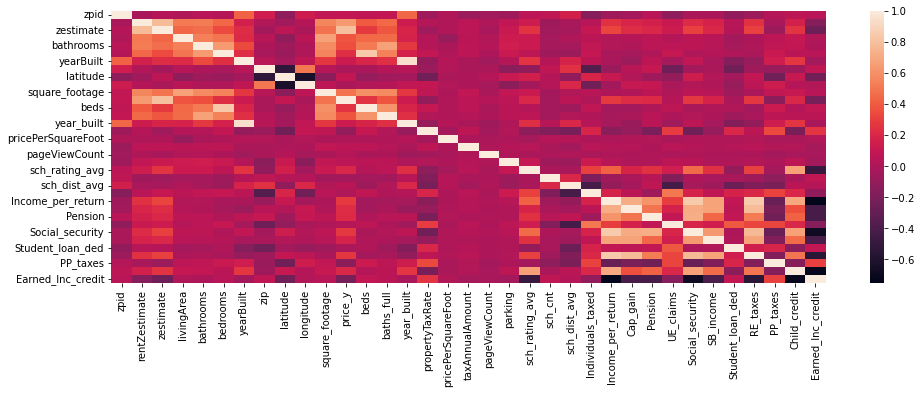

In [865]:
plt.figure(figsize = (16,5))
dataplot=sb.heatmap(clean_data_zil_tax.corr())
mp.show()

In [866]:
clean_data_zil_tax.taxAnnualAmount.isna().sum()/len(clean_data_zil_tax)

0.121765601217656

## <font color='blue'> Add Cap Rates to the data
* Ensure property taxes are aligned with tax rate and property value
* Assuming that expenses are 20% (utilities, maintenance etc.)
* Cap Rate = (NOI - Expenses)/Price

In [867]:
clean_data_zil_tax[clean_data_zil_tax['taxAnnualAmount']<2000].shape

(1570, 50)

In [868]:
#df.loc[df["A"] > 3, "A"] = 10
clean_data_zil_tax.loc[clean_data_zil_tax['taxAnnualAmount'] < 2000, 'taxAnnualAmount'] = np.nan

In [869]:
clean_data_zil_tax.loc[clean_data_zil_tax['taxAnnualAmount'] > 12000, 'taxAnnualAmount'] = np.nan

In [870]:
clean_data_zil_tax.taxAnnualAmount.isna().sum()

2136

In [871]:
clean_data_zil_tax['taxAnnualAmount'].describe()

count     2463.000000
mean      3388.568413
std       1111.097862
min       2000.000000
25%       2544.000000
50%       3159.000000
75%       3947.000000
max      11053.000000
Name: taxAnnualAmount, dtype: float64

In [872]:
clean_data_zil_tax[['propertyTaxRate']] = clean_data_zil_tax[['propertyTaxRate']].fillna(value=0.98/100)

In [873]:
#df['Cat1'].fillna(df['Cat2'])
clean_data_zil_tax['taxAnnualAmount'] = clean_data_zil_tax['zestimate']*clean_data_zil_tax['propertyTaxRate']/100

In [874]:
clean_data_zil_tax.head()

,zpid,rentZestimate,zestimate,livingArea,bathrooms,bedrooms,yearBuilt,address,city,state,zip,latitude,longitude,square_footage,price_y,census_county_name,beds,baths_full,year_built,propertyTaxRate,pricePerSquareFoot,propertyTypeDimension,taxAnnualAmount,dateSold,pageViewCount,hasAttachedProperty,poolFeatures,flooring,hasGarage,parking,hasWaterfrontView,lotSize,appliances,communityFeatures,propertyCondition,sch_rating_avg,sch_cnt,sch_dist_avg,Individuals_taxed,Income_per_return,Cap_gain,Pension,UE_claims,Social_security,SB_income,Student_loan_ded,RE_taxes,PP_taxes,Child_credit,Earned_Inc_credit
0,2.064281e+09,2175.41,347514.00,2103.0,2.0,4.0,2020.0,101 College Street,Kingsland,Georgia,31548,30.804209,-81.653325,2103,339900,"Camden, GA",4.0,2.0,2020.0,0.98,162.0,Single Family,3405.637200,5/31/22,0.0,False,NaN,"['Carpet', 'Tile']",True,2.0,NaN,0.45 Acres,"['Some Electric Appliances', 'Dishwasher', 'Di...","['Street Lights', 'Sidewalks', 'Walk to School']",NaN,7.333333,3.0,0.733333,20160.0,53.068519,6.500000,25.879817,3.546154,12.728319,36.895652,1.067021,3.122857,0.676744,2.125743,2.585463
2,9.103072e+07,2600.00,325200.00,2269.0,3.0,5.0,2004.0,169 School House Creek Drive,Saint Marys,Georgia,31558,30.767365,-81.588272,2269,310000,"Camden, GA",5.0,3.0,2004.0,0.98,134.0,Single Family,3186.960000,5/17/22,6.0,False,NaN,"['Carpet', 'Laminate', 'Vinyl']",True,0.0,NaN,"7,840 sqft","['Dishwasher', 'Oven/Range (Combo)', 'Refriger...","['Sidewalks', 'Street Lights']",Resale,7.666667,3.0,2.100000,18840.0,60.266882,17.274138,29.575630,3.477778,17.108497,46.670968,1.004819,4.105556,0.758537,2.175097,2.555497
4,1.112422e+08,1999.00,340500.00,1846.0,2.0,3.0,2004.0,1621 Sandpiper Court,Saint Marys,Georgia,31558,30.746731,-81.633995,1846,315000,"Camden, GA",3.0,2.0,2004.0,0.98,173.0,Single Family,3336.900000,5/13/22,20.0,False,['None'],['Tile'],True,2.0,NaN,"8,276 sqft","['Dryer', 'Dishwasher', 'Disposal', 'Microwave...","['Boat Facilities', 'Gated', 'Park', 'Street L...",NaN,7.666667,3.0,3.766667,18840.0,60.266882,17.274138,29.575630,3.477778,17.108497,46.670968,1.004819,4.105556,0.758537,2.175097,2.555497
6,2.090936e+09,1999.00,326164.00,1953.0,2.0,3.0,2018.0,346 Laurel Landing Boulevard,Kingsland,Georgia,31548,30.791878,-81.676750,1977,310000,"Camden, GA",3.0,2.0,2017.0,0.98,NaN,Condo,3196.407200,NaN,0.0,False,NaN,NaN,False,0.0,NaN,NaN,NaN,NaN,NaN,8.000000,3.0,2.600000,20160.0,53.068519,6.500000,25.879817,3.546154,12.728319,36.895652,1.067021,3.122857,0.676744,2.125743,2.585463
8,2.064330e+09,1939.51,365974.43,1835.0,2.0,3.0,2022.0,81 Ossabaw Way,Waverly,Georgia,31565,31.104492,-81.604486,1835,369900,"Camden, GA",3.0,2.0,2022.0,0.98,202.0,Single Family,3586.549414,8/15/22,5.0,False,NaN,['Tile'],True,2.0,NaN,1.21 Acres,"['Dishwasher', 'Microwave', 'Oven/Range (Combo...","['Clubhouse', 'Gated', 'Golf', 'Lake', 'Fitnes...",New Construction,7.333333,3.0,16.200000,1800.0,66.877419,6.375000,32.572000,0.000000,17.610526,65.228571,1.160000,4.311111,0.400000,1.936000,2.294118


In [875]:
clean_data_zil_tax['taxAnnualAmount'].describe()

count     4599.000000
mean      4173.320701
std       1271.086370
min         22.326903
25%       3270.825000
50%       4036.333590
75%       4913.125000
max      16506.880000
Name: taxAnnualAmount, dtype: float64

In [876]:
clean_data_zil_tax.columns

Index(['zpid', 'rentZestimate', 'zestimate', 'livingArea', 'bathrooms',
       'bedrooms', 'yearBuilt', 'address', 'city', 'state', 'zip', 'latitude',
       'longitude', 'square_footage', 'price_y', 'census_county_name', 'beds',
       'baths_full', 'year_built', 'propertyTaxRate', 'pricePerSquareFoot',
       'propertyTypeDimension', 'taxAnnualAmount', 'dateSold', 'pageViewCount',
       'hasAttachedProperty', 'poolFeatures', 'flooring', 'hasGarage',
       'parking', 'hasWaterfrontView', 'lotSize', 'appliances',
       'communityFeatures', 'propertyCondition', 'sch_rating_avg', 'sch_cnt',
       'sch_dist_avg', 'Individuals_taxed', 'Income_per_return', 'Cap_gain',
       'Pension', 'UE_claims', 'Social_security', 'SB_income',
       'Student_loan_ded', 'RE_taxes', 'PP_taxes', 'Child_credit',
       'Earned_Inc_credit'],
      dtype='object')

In [877]:
clean_data_zil_tax[['address','zestimate','price_y']].corr()

,zestimate,price_y
zestimate,1.000000,0.795307
price_y,0.795307,1.000000


In [878]:
clean_data_zil_tax[['taxAnnualAmount',
                    'rentZestimate']].isna().sum()

taxAnnualAmount    0
rentZestimate      0
dtype: int64

In [879]:
clean_data_zil_tax['NOI'] = clean_data_zil_tax['rentZestimate']*12 

In [880]:
clean_data_zil_tax['Expenses'] = clean_data_zil_tax['NOI']*0.2 + clean_data_zil_tax['taxAnnualAmount']

In [881]:
clean_data_zil_tax[['NOI','Expenses']]

,NOI,Expenses
0,26104.92,8626.621200
2,31200.00,9426.960000
4,23988.00,8134.500000
6,23988.00,7994.007200
8,23274.12,8241.373414
...,...,...
6511,22800.00,9533.700000
6512,24588.00,9048.780000
6513,43188.00,13174.971400
6514,43188.00,12529.240000


In [882]:
clean_data_zil_tax['cap_rate'] = (clean_data_zil_tax['NOI'] - 
                                  clean_data_zil_tax['Expenses'])/clean_data_zil_tax['price_y']

In [883]:
clean_data_zil_tax.head()

,zpid,rentZestimate,zestimate,livingArea,bathrooms,bedrooms,yearBuilt,address,city,state,zip,latitude,longitude,square_footage,price_y,census_county_name,beds,baths_full,year_built,propertyTaxRate,pricePerSquareFoot,propertyTypeDimension,taxAnnualAmount,dateSold,pageViewCount,hasAttachedProperty,poolFeatures,flooring,hasGarage,parking,hasWaterfrontView,lotSize,appliances,communityFeatures,propertyCondition,sch_rating_avg,sch_cnt,sch_dist_avg,Individuals_taxed,Income_per_return,Cap_gain,Pension,UE_claims,Social_security,SB_income,Student_loan_ded,RE_taxes,PP_taxes,Child_credit,Earned_Inc_credit,NOI,Expenses,cap_rate
0,2.064281e+09,2175.41,347514.00,2103.0,2.0,4.0,2020.0,101 College Street,Kingsland,Georgia,31548,30.804209,-81.653325,2103,339900,"Camden, GA",4.0,2.0,2020.0,0.98,162.0,Single Family,3405.637200,5/31/22,0.0,False,NaN,"['Carpet', 'Tile']",True,2.0,NaN,0.45 Acres,"['Some Electric Appliances', 'Dishwasher', 'Di...","['Street Lights', 'Sidewalks', 'Walk to School']",NaN,7.333333,3.0,0.733333,20160.0,53.068519,6.500000,25.879817,3.546154,12.728319,36.895652,1.067021,3.122857,0.676744,2.125743,2.585463,26104.92,8626.621200,0.051422
2,9.103072e+07,2600.00,325200.00,2269.0,3.0,5.0,2004.0,169 School House Creek Drive,Saint Marys,Georgia,31558,30.767365,-81.588272,2269,310000,"Camden, GA",5.0,3.0,2004.0,0.98,134.0,Single Family,3186.960000,5/17/22,6.0,False,NaN,"['Carpet', 'Laminate', 'Vinyl']",True,0.0,NaN,"7,840 sqft","['Dishwasher', 'Oven/Range (Combo)', 'Refriger...","['Sidewalks', 'Street Lights']",Resale,7.666667,3.0,2.100000,18840.0,60.266882,17.274138,29.575630,3.477778,17.108497,46.670968,1.004819,4.105556,0.758537,2.175097,2.555497,31200.00,9426.960000,0.070236
4,1.112422e+08,1999.00,340500.00,1846.0,2.0,3.0,2004.0,1621 Sandpiper Court,Saint Marys,Georgia,31558,30.746731,-81.633995,1846,315000,"Camden, GA",3.0,2.0,2004.0,0.98,173.0,Single Family,3336.900000,5/13/22,20.0,False,['None'],['Tile'],True,2.0,NaN,"8,276 sqft","['Dryer', 'Dishwasher', 'Disposal', 'Microwave...","['Boat Facilities', 'Gated', 'Park', 'Street L...",NaN,7.666667,3.0,3.766667,18840.0,60.266882,17.274138,29.575630,3.477778,17.108497,46.670968,1.004819,4.105556,0.758537,2.175097,2.555497,23988.00,8134.500000,0.050329
6,2.090936e+09,1999.00,326164.00,1953.0,2.0,3.0,2018.0,346 Laurel Landing Boulevard,Kingsland,Georgia,31548,30.791878,-81.676750,1977,310000,"Camden, GA",3.0,2.0,2017.0,0.98,NaN,Condo,3196.407200,NaN,0.0,False,NaN,NaN,False,0.0,NaN,NaN,NaN,NaN,NaN,8.000000,3.0,2.600000,20160.0,53.068519,6.500000,25.879817,3.546154,12.728319,36.895652,1.067021,3.122857,0.676744,2.125743,2.585463,23988.00,7994.007200,0.051594
8,2.064330e+09,1939.51,365974.43,1835.0,2.0,3.0,2022.0,81 Ossabaw Way,Waverly,Georgia,31565,31.104492,-81.604486,1835,369900,"Camden, GA",3.0,2.0,2022.0,0.98,202.0,Single Family,3586.549414,8/15/22,5.0,False,NaN,['Tile'],True,2.0,NaN,1.21 Acres,"['Dishwasher', 'Microwave', 'Oven/Range (Combo...","['Clubhouse', 'Gated', 'Golf', 'Lake', 'Fitnes...",New Construction,7.333333,3.0,16.200000,1800.0,66.877419,6.375000,32.572000,0.000000,17.610526,65.228571,1.160000,4.311111,0.400000,1.936000,2.294118,23274.12,8241.373414,0.040640


In [884]:
clean_data_zil_tax['total_appliances'] = clean_data_zil_tax.appliances.str.replace("'","").str.count(',')+1

In [885]:
clean_data_zil_tax['total_community_feat'] = clean_data_zil_tax.communityFeatures.str.replace("'","").str.count(',')+1

In [886]:
clean_data_zil_tax.to_csv('clean_data_zil_tax.csv')

### <font color = 'blue'> Creating a Category of Type of Property - New, Remodeled or Resale
The idea is that good deals might be hiding in resale or remodeled?

In [887]:
clean_data_zil_tax.propertyCondition.value_counts()

Resale                                             2612
New Construction                                    514
Updated/Remodeled                                   249
Under Construction                                  174
To Be Built                                          52
Fixer                                                44
New Construction,Under Construction                  15
Updated/Remodeled,Resale                              6
50+ Years                                             3
Completed                                             2
Pre Construction                                      2
ReSale                                                1
New Construction,To Be Built,Under Construction       1
Fixer,Updated/Remodeled                               1
30+ Years                                             1
Name: propertyCondition, dtype: int64

In [888]:
clean_data_zil_tax['Prop_Cond_Grp'] = np.where(clean_data_zil_tax['propertyCondition'].isin(['New Construction', 
                                              'Under Construction',
                                              'To Be Built',
                                             'New Construction,Under Construction',
                                              'Completed',
                                              'Pre Construction',
                                              'New Construction,To Be Built,Under Construction',                                           
                                             ]), 'New',
                                             np.where(clean_data_zil_tax['propertyCondition'].isin(['Updated/Remodeled', 
                                              'Updated/Remodeled,Resale',
                                              'Fixer,Updated/Remodeled']), 'Remodeled', 'Resale'))
                   
                   #np.where(df['col2']<15, 'value3', 'value4')))

In [889]:
clean_data_zil_tax.Prop_Cond_Grp.value_counts()

Resale       3583
New           760
Remodeled     256
Name: Prop_Cond_Grp, dtype: int64

In [890]:
clean_data_zil_tax.head()

,zpid,rentZestimate,zestimate,livingArea,bathrooms,bedrooms,yearBuilt,address,city,state,zip,latitude,longitude,square_footage,price_y,census_county_name,beds,baths_full,year_built,propertyTaxRate,pricePerSquareFoot,propertyTypeDimension,taxAnnualAmount,dateSold,pageViewCount,hasAttachedProperty,poolFeatures,flooring,hasGarage,parking,hasWaterfrontView,lotSize,appliances,communityFeatures,propertyCondition,sch_rating_avg,sch_cnt,sch_dist_avg,Individuals_taxed,Income_per_return,Cap_gain,Pension,UE_claims,Social_security,SB_income,Student_loan_ded,RE_taxes,PP_taxes,Child_credit,Earned_Inc_credit,NOI,Expenses,cap_rate,total_appliances,total_community_feat,Prop_Cond_Grp
0,2.064281e+09,2175.41,347514.00,2103.0,2.0,4.0,2020.0,101 College Street,Kingsland,Georgia,31548,30.804209,-81.653325,2103,339900,"Camden, GA",4.0,2.0,2020.0,0.98,162.0,Single Family,3405.637200,5/31/22,0.0,False,NaN,"['Carpet', 'Tile']",True,2.0,NaN,0.45 Acres,"['Some Electric Appliances', 'Dishwasher', 'Di...","['Street Lights', 'Sidewalks', 'Walk to School']",NaN,7.333333,3.0,0.733333,20160.0,53.068519,6.500000,25.879817,3.546154,12.728319,36.895652,1.067021,3.122857,0.676744,2.125743,2.585463,26104.92,8626.621200,0.051422,7.0,3.0,Resale
2,9.103072e+07,2600.00,325200.00,2269.0,3.0,5.0,2004.0,169 School House Creek Drive,Saint Marys,Georgia,31558,30.767365,-81.588272,2269,310000,"Camden, GA",5.0,3.0,2004.0,0.98,134.0,Single Family,3186.960000,5/17/22,6.0,False,NaN,"['Carpet', 'Laminate', 'Vinyl']",True,0.0,NaN,"7,840 sqft","['Dishwasher', 'Oven/Range (Combo)', 'Refriger...","['Sidewalks', 'Street Lights']",Resale,7.666667,3.0,2.100000,18840.0,60.266882,17.274138,29.575630,3.477778,17.108497,46.670968,1.004819,4.105556,0.758537,2.175097,2.555497,31200.00,9426.960000,0.070236,4.0,2.0,Resale
4,1.112422e+08,1999.00,340500.00,1846.0,2.0,3.0,2004.0,1621 Sandpiper Court,Saint Marys,Georgia,31558,30.746731,-81.633995,1846,315000,"Camden, GA",3.0,2.0,2004.0,0.98,173.0,Single Family,3336.900000,5/13/22,20.0,False,['None'],['Tile'],True,2.0,NaN,"8,276 sqft","['Dryer', 'Dishwasher', 'Disposal', 'Microwave...","['Boat Facilities', 'Gated', 'Park', 'Street L...",NaN,7.666667,3.0,3.766667,18840.0,60.266882,17.274138,29.575630,3.477778,17.108497,46.670968,1.004819,4.105556,0.758537,2.175097,2.555497,23988.00,8134.500000,0.050329,10.0,6.0,Resale
6,2.090936e+09,1999.00,326164.00,1953.0,2.0,3.0,2018.0,346 Laurel Landing Boulevard,Kingsland,Georgia,31548,30.791878,-81.676750,1977,310000,"Camden, GA",3.0,2.0,2017.0,0.98,NaN,Condo,3196.407200,NaN,0.0,False,NaN,NaN,False,0.0,NaN,NaN,NaN,NaN,NaN,8.000000,3.0,2.600000,20160.0,53.068519,6.500000,25.879817,3.546154,12.728319,36.895652,1.067021,3.122857,0.676744,2.125743,2.585463,23988.00,7994.007200,0.051594,NaN,NaN,Resale
8,2.064330e+09,1939.51,365974.43,1835.0,2.0,3.0,2022.0,81 Ossabaw Way,Waverly,Georgia,31565,31.104492,-81.604486,1835,369900,"Camden, GA",3.0,2.0,2022.0,0.98,202.0,Single Family,3586.549414,8/15/22,5.0,False,NaN,['Tile'],True,2.0,NaN,1.21 Acres,"['Dishwasher', 'Microwave', 'Oven/Range (Combo...","['Clubhouse', 'Gated', 'Golf', 'Lake', 'Fitnes...",New Construction,7.333333,3.0,16.200000,1800.0,66.877419,6.375000,32.572000,0.000000,17.610526,65.228571,1.160000,4.311111,0.400000,1.936000,2.294118,23274.12,8241.373414,0.040640,4.0,7.0,New


In [891]:
clean_data_zil_tax.lotSize.isna().sum()

325

### <font color = 'blue'> The LOT Size can make the property very attractive, here we convert Acres to Square Feet and then impute missing values using an average conversaion factor

In [892]:
#0.45 Acres
clean_data_zil_tax[['Lvalue','Lunits']] = clean_data_zil_tax['lotSize'].str.split(' ',expand=True)


In [893]:
clean_data_zil_tax.head()

,zpid,rentZestimate,zestimate,livingArea,bathrooms,bedrooms,yearBuilt,address,city,state,zip,latitude,longitude,square_footage,price_y,census_county_name,beds,baths_full,year_built,propertyTaxRate,pricePerSquareFoot,propertyTypeDimension,taxAnnualAmount,dateSold,pageViewCount,hasAttachedProperty,poolFeatures,flooring,hasGarage,parking,hasWaterfrontView,lotSize,appliances,communityFeatures,propertyCondition,sch_rating_avg,sch_cnt,sch_dist_avg,Individuals_taxed,Income_per_return,Cap_gain,Pension,UE_claims,Social_security,SB_income,Student_loan_ded,RE_taxes,PP_taxes,Child_credit,Earned_Inc_credit,NOI,Expenses,cap_rate,total_appliances,total_community_feat,Prop_Cond_Grp,Lvalue,Lunits
0,2.064281e+09,2175.41,347514.00,2103.0,2.0,4.0,2020.0,101 College Street,Kingsland,Georgia,31548,30.804209,-81.653325,2103,339900,"Camden, GA",4.0,2.0,2020.0,0.98,162.0,Single Family,3405.637200,5/31/22,0.0,False,NaN,"['Carpet', 'Tile']",True,2.0,NaN,0.45 Acres,"['Some Electric Appliances', 'Dishwasher', 'Di...","['Street Lights', 'Sidewalks', 'Walk to School']",NaN,7.333333,3.0,0.733333,20160.0,53.068519,6.500000,25.879817,3.546154,12.728319,36.895652,1.067021,3.122857,0.676744,2.125743,2.585463,26104.92,8626.621200,0.051422,7.0,3.0,Resale,0.45,Acres
2,9.103072e+07,2600.00,325200.00,2269.0,3.0,5.0,2004.0,169 School House Creek Drive,Saint Marys,Georgia,31558,30.767365,-81.588272,2269,310000,"Camden, GA",5.0,3.0,2004.0,0.98,134.0,Single Family,3186.960000,5/17/22,6.0,False,NaN,"['Carpet', 'Laminate', 'Vinyl']",True,0.0,NaN,"7,840 sqft","['Dishwasher', 'Oven/Range (Combo)', 'Refriger...","['Sidewalks', 'Street Lights']",Resale,7.666667,3.0,2.100000,18840.0,60.266882,17.274138,29.575630,3.477778,17.108497,46.670968,1.004819,4.105556,0.758537,2.175097,2.555497,31200.00,9426.960000,0.070236,4.0,2.0,Resale,"7,840",sqft
4,1.112422e+08,1999.00,340500.00,1846.0,2.0,3.0,2004.0,1621 Sandpiper Court,Saint Marys,Georgia,31558,30.746731,-81.633995,1846,315000,"Camden, GA",3.0,2.0,2004.0,0.98,173.0,Single Family,3336.900000,5/13/22,20.0,False,['None'],['Tile'],True,2.0,NaN,"8,276 sqft","['Dryer', 'Dishwasher', 'Disposal', 'Microwave...","['Boat Facilities', 'Gated', 'Park', 'Street L...",NaN,7.666667,3.0,3.766667,18840.0,60.266882,17.274138,29.575630,3.477778,17.108497,46.670968,1.004819,4.105556,0.758537,2.175097,2.555497,23988.00,8134.500000,0.050329,10.0,6.0,Resale,"8,276",sqft
6,2.090936e+09,1999.00,326164.00,1953.0,2.0,3.0,2018.0,346 Laurel Landing Boulevard,Kingsland,Georgia,31548,30.791878,-81.676750,1977,310000,"Camden, GA",3.0,2.0,2017.0,0.98,NaN,Condo,3196.407200,NaN,0.0,False,NaN,NaN,False,0.0,NaN,NaN,NaN,NaN,NaN,8.000000,3.0,2.600000,20160.0,53.068519,6.500000,25.879817,3.546154,12.728319,36.895652,1.067021,3.122857,0.676744,2.125743,2.585463,23988.00,7994.007200,0.051594,NaN,NaN,Resale,NaN,NaN
8,2.064330e+09,1939.51,365974.43,1835.0,2.0,3.0,2022.0,81 Ossabaw Way,Waverly,Georgia,31565,31.104492,-81.604486,1835,369900,"Camden, GA",3.0,2.0,2022.0,0.98,202.0,Single Family,3586.549414,8/15/22,5.0,False,NaN,['Tile'],True,2.0,NaN,1.21 Acres,"['Dishwasher', 'Microwave', 'Oven/Range (Combo...","['Clubhouse', 'Gated', 'Golf', 'Lake', 'Fitnes...",New Construction,7.333333,3.0,16.200000,1800.0,66.877419,6.375000,32.572000,0.000000,17.610526,65.228571,1.160000,4.311111,0.400000,1.936000,2.294118,23274.12,8241.373414,0.040640,4.0,7.0,New,1.21,Acres


In [894]:
clean_data_zil_tax.Lvalue.isna().sum()

325

In [895]:
clean_data_zil_tax.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4599 entries, 0 to 6515
Data columns (total 58 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   zpid                   4599 non-null   float64
 1   rentZestimate          4599 non-null   float64
 2   zestimate              4599 non-null   float64
 3   livingArea             4599 non-null   float64
 4   bathrooms              4599 non-null   float64
 5   bedrooms               4599 non-null   float64
 6   yearBuilt              4599 non-null   float64
 7   address                4599 non-null   object 
 8   city                   4599 non-null   object 
 9   state                  4599 non-null   object 
 10  zip                    4599 non-null   int64  
 11  latitude               4599 non-null   float64
 12  longitude              4599 non-null   float64
 13  square_footage         4599 non-null   int64  
 14  price_y                4599 non-null   int64  
 15  cens

In [896]:
clean_data_zil_tax['Lvalue'] = clean_data_zil_tax['Lvalue'].str.replace(r',', '').astype(float)
#s2 = s1.astype('int64', copy=False)


In [897]:
clean_data_zil_tax['Lot_Size_SqFt'] = np.where(clean_data_zil_tax['Lunits'] == 'Acres',
                                               clean_data_zil_tax['Lvalue'] * 43560,
                                               clean_data_zil_tax['Lvalue'])


In [898]:
con_fact = np.mean(clean_data_zil_tax['livingArea']/clean_data_zil_tax['Lot_Size_SqFt'])

In [899]:
clean_data_zil_tax['Lot_Size_SqFt'] = clean_data_zil_tax['Lot_Size_SqFt'].fillna(clean_data_zil_tax['livingArea']/con_fact)

In [900]:
clean_data_zil_tax.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4599 entries, 0 to 6515
Data columns (total 59 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   zpid                   4599 non-null   float64
 1   rentZestimate          4599 non-null   float64
 2   zestimate              4599 non-null   float64
 3   livingArea             4599 non-null   float64
 4   bathrooms              4599 non-null   float64
 5   bedrooms               4599 non-null   float64
 6   yearBuilt              4599 non-null   float64
 7   address                4599 non-null   object 
 8   city                   4599 non-null   object 
 9   state                  4599 non-null   object 
 10  zip                    4599 non-null   int64  
 11  latitude               4599 non-null   float64
 12  longitude              4599 non-null   float64
 13  square_footage         4599 non-null   int64  
 14  price_y                4599 non-null   int64  
 15  cens

In [901]:
clean_data_zil_tax.columns

Index(['zpid', 'rentZestimate', 'zestimate', 'livingArea', 'bathrooms',
       'bedrooms', 'yearBuilt', 'address', 'city', 'state', 'zip', 'latitude',
       'longitude', 'square_footage', 'price_y', 'census_county_name', 'beds',
       'baths_full', 'year_built', 'propertyTaxRate', 'pricePerSquareFoot',
       'propertyTypeDimension', 'taxAnnualAmount', 'dateSold', 'pageViewCount',
       'hasAttachedProperty', 'poolFeatures', 'flooring', 'hasGarage',
       'parking', 'hasWaterfrontView', 'lotSize', 'appliances',
       'communityFeatures', 'propertyCondition', 'sch_rating_avg', 'sch_cnt',
       'sch_dist_avg', 'Individuals_taxed', 'Income_per_return', 'Cap_gain',
       'Pension', 'UE_claims', 'Social_security', 'SB_income',
       'Student_loan_ded', 'RE_taxes', 'PP_taxes', 'Child_credit',
       'Earned_Inc_credit', 'NOI', 'Expenses', 'cap_rate', 'total_appliances',
       'total_community_feat', 'Prop_Cond_Grp', 'Lvalue', 'Lunits',
       'Lot_Size_SqFt'],
      dtype='object')

In [902]:
df_c = clean_data_zil_tax[['zpid', 'rentZestimate', 'zestimate', 'livingArea', 'bathrooms',
       'bedrooms', 'yearBuilt', 'square_footage', 'price_y', 'pricePerSquareFoot',
       'taxAnnualAmount', 'pageViewCount','Lot_Size_SqFt',
       'hasAttachedProperty', 'poolFeatures', 'flooring', 'hasGarage',
       'parking', 'hasWaterfrontView', 'total_appliances','total_community_feat','Prop_Cond_Grp',
       'sch_rating_avg', 'sch_cnt',
       'sch_dist_avg', 'Individuals_taxed', 'Income_per_return', 'Cap_gain',
       'Pension', 'UE_claims', 'Social_security', 'SB_income',
       'Student_loan_ded', 'RE_taxes', 'PP_taxes', 'Child_credit',
       'Earned_Inc_credit', 'cap_rate']]

In [903]:
df_c.head()

,zpid,rentZestimate,zestimate,livingArea,bathrooms,bedrooms,yearBuilt,square_footage,price_y,pricePerSquareFoot,taxAnnualAmount,pageViewCount,Lot_Size_SqFt,hasAttachedProperty,poolFeatures,flooring,hasGarage,parking,hasWaterfrontView,total_appliances,total_community_feat,Prop_Cond_Grp,sch_rating_avg,sch_cnt,sch_dist_avg,Individuals_taxed,Income_per_return,Cap_gain,Pension,UE_claims,Social_security,SB_income,Student_loan_ded,RE_taxes,PP_taxes,Child_credit,Earned_Inc_credit,cap_rate
0,2.064281e+09,2175.41,347514.00,2103.0,2.0,4.0,2020.0,2103,339900,162.0,3405.637200,0.0,19602.000000,False,NaN,"['Carpet', 'Tile']",True,2.0,NaN,7.0,3.0,Resale,7.333333,3.0,0.733333,20160.0,53.068519,6.500000,25.879817,3.546154,12.728319,36.895652,1.067021,3.122857,0.676744,2.125743,2.585463,0.051422
2,9.103072e+07,2600.00,325200.00,2269.0,3.0,5.0,2004.0,2269,310000,134.0,3186.960000,6.0,7840.000000,False,NaN,"['Carpet', 'Laminate', 'Vinyl']",True,0.0,NaN,4.0,2.0,Resale,7.666667,3.0,2.100000,18840.0,60.266882,17.274138,29.575630,3.477778,17.108497,46.670968,1.004819,4.105556,0.758537,2.175097,2.555497,0.070236
4,1.112422e+08,1999.00,340500.00,1846.0,2.0,3.0,2004.0,1846,315000,173.0,3336.900000,20.0,8276.000000,False,['None'],['Tile'],True,2.0,NaN,10.0,6.0,Resale,7.666667,3.0,3.766667,18840.0,60.266882,17.274138,29.575630,3.477778,17.108497,46.670968,1.004819,4.105556,0.758537,2.175097,2.555497,0.050329
6,2.090936e+09,1999.00,326164.00,1953.0,2.0,3.0,2018.0,1977,310000,NaN,3196.407200,0.0,4012.813253,False,NaN,NaN,False,0.0,NaN,NaN,NaN,Resale,8.000000,3.0,2.600000,20160.0,53.068519,6.500000,25.879817,3.546154,12.728319,36.895652,1.067021,3.122857,0.676744,2.125743,2.585463,0.051594
8,2.064330e+09,1939.51,365974.43,1835.0,2.0,3.0,2022.0,1835,369900,202.0,3586.549414,5.0,52707.600000,False,NaN,['Tile'],True,2.0,NaN,4.0,7.0,New,7.333333,3.0,16.200000,1800.0,66.877419,6.375000,32.572000,0.000000,17.610526,65.228571,1.160000,4.311111,0.400000,1.936000,2.294118,0.040640
